## Problem Statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

 

For many incumbent operators, retaining high profitable customers is the number one business goal.

 

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

## Solution Approach 

The given customer-level data of a leading telecom firm would be analyzed to build predictive models to identify customers at high risk of churn and also identify the main indicators of churn.

In [3]:
# Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score
from imblearn.combine import SMOTETomek # for imbalancing
from imblearn.over_sampling  import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
%matplotlib inline
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Read the data
raw_data = pd.read_csv('telecom_churn_data.csv')

In [5]:
raw_data.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9   arpu_6     ...      sachet_3g_9  fb_user_6  \
0            9/30/2014  197.385     ...                0        1.0   
1            9/30/2014   34.047     ...                0        NaN   
2            9/30/2014  167.690     ...                0        NaN   
3            9/30/2014  221.338     ...                0        NaN   
4            9/30/2014  261.636     ...                0        0.0   

   fb_user_7  fb_user_8  fb_user_9   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  \
0        1.0        1.0        NaN   968        30.4         0.0      101.20   
1        1.0        1.0        NaN  1006         0.0         0.0        0.00   
2        NaN        NaN        1.0  1103         0.0         0.0        4.17   
3        NaN        NaN        NaN  2491         0.0         0.0        0.00   
4        NaN        NaN        NaN  1526         0.0         0.0        0.00   

   sep_vbc_3g  
0        3.58  
1        0.00  
2        0.00  
3        0.00  
4        0.00  

[5 rows x 226 columns]

In [6]:
# Getting info on the dataframe
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [7]:
# Listing out all columns for further operations.
raw_data.columns.values

array(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6', 'arpu_7',
       'arpu_8', 'arpu_9', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8',
       'onnet_mou_9', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       'offnet_mou_9', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8',
       'roam_ic_mou_9', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'roam_og_mou_9', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7',
       'loc_og_t2t_mou_8', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_6',
       'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2m_mou_9',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2f_mou_9', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7',
       'loc_og_t2c_mou_8', 'loc_og_t2c_mou_9', 'loc_og_mou_6',
       'loc_og_mou_7', 'loc_og_mou_8', 'loc_og_mou_9', 'std_og_t2t_mou_6',
       'std_og_t2t

## Perfroming initial Data Preparation. This step includes:
1. Extraction of High-Value Customers
2. Tagging Customers as Churn and Not-Churn
3. Dropping the data related to the 9th month
4. Removin null values from the data-set

In [8]:
# Adding new column to get the average recharge amount in the first two months
raw_data['avg_rech_amt_6_7'] = (raw_data['total_rech_amt_6'] + raw_data['total_rech_amt_7'])/2
raw_data['avg_rech_amt_6_7'].describe()

count    99999.000000
mean       325.238792
std        370.833466
min          0.000000
25%        115.000000
50%        229.000000
75%        419.000000
max      37762.500000
Name: avg_rech_amt_6_7, dtype: float64

In [9]:
# Filtering out High-Value Customers
high_value_customers = raw_data[(raw_data.avg_rech_amt_6_7 > raw_data['avg_rech_amt_6_7'].quantile(0.7))]

In [10]:
# Getting info on the dataframe
high_value_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29979 entries, 7 to 99997
Columns: 227 entries, mobile_number to avg_rech_amt_6_7
dtypes: float64(180), int64(35), object(12)
memory usage: 52.1+ MB


29,979 rows remain in the filtered dataset.

In [11]:
# Defining function for tagging customers as churn or not churn
def mapChurn(df):
    if (int(df['total_ic_mou_9']) == 0 or int(df['total_og_mou_9']) == 0) and int(df['vol_2g_mb_9']) == 0 and int(df['vol_3g_mb_9']) == 0:
        return 1
    else:
        return 0

In [12]:
# Tagging customers as churn or not churn
high_value_customers['churn'] = high_value_customers.apply(mapChurn, axis=1)

In [13]:
# Delete the 9th column
# Check the columns to be deleted before the actual delete operation

lst_9mnthCol = list(high_value_customers.filter(regex='_9'))
df_9mnthCol = pd.DataFrame(data=lst_9mnthCol)
#df_9mnthCol

In [14]:
# Dropping the columns corresponding to 9th month

high_value_customers = high_value_customers[high_value_customers.columns.drop(list(high_value_customers.filter(regex='_9')))]
high_value_customers.head()        

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
7      7000701601        109             0.0             0.0             0.0   
8      7001524846        109             0.0             0.0             0.0   
13     7002191713        109             0.0             0.0             0.0   
16     7000875565        109             0.0             0.0             0.0   
17     7000187447        109             0.0             0.0             0.0   

   last_date_of_month_6 last_date_of_month_7 last_date_of_month_8    arpu_6  \
7             6/30/2014            7/31/2014            8/31/2014  1069.180   
8             6/30/2014            7/31/2014            8/31/2014   378.721   
13            6/30/2014            7/31/2014            8/31/2014   492.846   
16            6/30/2014            7/31/2014            8/31/2014   430.975   
17            6/30/2014            7/31/2014            8/31/2014   690.008   

      arpu_7  ...    fb_user_6  fb_user_7  fb_user_8   aon  aug_vbc_3g  \
7   1349.850  ...          NaN        NaN        NaN   802       57.74   
8    492.223  ...          NaN        1.0        1.0   315       21.03   
13   205.671  ...          NaN        NaN        1.0  2607        0.00   
16   299.869  ...          NaN        NaN        NaN   511        0.00   
17    18.980  ...          NaN        NaN        NaN   667        0.00   

    jul_vbc_3g  jun_vbc_3g  sep_vbc_3g  avg_rech_amt_6_7  churn  
7        19.38       18.74         0.0            1185.0      1  
8       910.65      122.16         0.0             519.0      0  
13        0.00        0.00         0.0             380.0      0  
16        2.45       21.89         0.0             459.0      0  
17        0.00        0.00         0.0             408.0      0  

[5 rows x 174 columns]

In [15]:
high_value_customers.columns

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'arpu_6', 'arpu_7',
       ...
       'fb_user_6', 'fb_user_7', 'fb_user_8', 'aon', 'aug_vbc_3g',
       'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g', 'avg_rech_amt_6_7', 'churn'],
      dtype='object', length=174)

total columns reduced to 174 from original 228

In [16]:
# Total number of columns with null values
len(high_value_customers.columns[high_value_customers.isna().any()])

125

In [17]:
# Total number of columns with null values > 10000
len(high_value_customers.columns[high_value_customers.isna().sum() > 10000])

30

In [18]:
# Removing columns with more than 10000 null values
high_value_customers = high_value_customers[high_value_customers
                                            .columns
                                            .drop(list(high_value_customers
                                                       .columns[high_value_customers
                                                                .isna()
                                                                .sum() > 10000]))]

In [19]:
high_value_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29979 entries, 7 to 99997
Columns: 144 entries, mobile_number to churn
dtypes: float64(110), int64(28), object(6)
memory usage: 33.2+ MB


144 columns remain after dropping.

In [20]:
# Checking for number of rows with null values.
high_value_customers[high_value_customers.isna().any(axis=1)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1524 entries, 77 to 99827
Columns: 144 entries, mobile_number to churn
dtypes: float64(110), int64(28), object(6)
memory usage: 1.7+ MB


In [21]:
# There are 1524 rows with null values. Dropping them.
high_value_customers = high_value_customers.dropna(axis = 0, how ='any')
high_value_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28455 entries, 7 to 99997
Columns: 144 entries, mobile_number to churn
dtypes: float64(110), int64(28), object(6)
memory usage: 31.5+ MB


28455 rows remain with 144 columns

In [22]:
# Ensuring no null values is present in the columns.
len(high_value_customers.columns[high_value_customers.isna().sum() > 0])

0

## Performing EDA on the Data. This step includes:
1. Visualizing the data.
2. Deriving new features.
3. Dropping the unnecessary features

In [23]:
# Categorical Data Columns
high_value_customers.select_dtypes(include=[object]).columns

Index(['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'],
      dtype='object')

In [24]:
high_value_customers[['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8']].head()

last_date_of_month_6 last_date_of_month_7 last_date_of_month_8
7             6/30/2014            7/31/2014            8/31/2014
8             6/30/2014            7/31/2014            8/31/2014
13            6/30/2014            7/31/2014            8/31/2014
16            6/30/2014            7/31/2014            8/31/2014
17            6/30/2014            7/31/2014            8/31/2014

In [25]:
# Dropping cols 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8' 
# as it contains same data in all rows
high_value_customers = high_value_customers.drop(['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8']
                                                , axis=1)

In [26]:
pd.options.display.max_columns = None
high_value_customers.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
7      7000701601        109             0.0             0.0             0.0   
8      7001524846        109             0.0             0.0             0.0   
13     7002191713        109             0.0             0.0             0.0   
16     7000875565        109             0.0             0.0             0.0   
17     7000187447        109             0.0             0.0             0.0   

      arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
7   1069.180  1349.850  3171.480        57.84        54.68        52.29   
8    378.721   492.223   137.362       413.69       351.03        35.08   
13   492.846   205.671   593.260       501.76       108.39       534.24   
16   430.975   299.869   187.894        50.51        74.01        70.61   
17   690.008    18.980    25.499      1185.91         9.28         7.79   

    offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
7         453.43        567.16        325.91          16.23          33.49   
8          94.66         80.63        136.48           0.00           0.00   
13        413.31        119.28        482.46          23.53         144.24   
16        296.29        229.74        162.76           0.00           2.83   
17         61.64          0.00          5.54           0.00           4.76   

    roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
7           31.64          23.74          12.59          38.06   
8            0.00           0.00           0.00           0.00   
13          72.11           7.98          35.26           1.44   
16           0.00           0.00          17.74           0.00   
17           4.81           0.00           8.46          13.34   

    loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
7              51.39             31.38             40.28            308.63   
8             297.13            217.59             12.49             80.96   
13             49.63              6.19             36.01            151.13   
16             42.61             65.16             67.38            273.29   
17             38.99              0.00              0.00             58.54   

    loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
7             447.38            162.28             62.13             55.14   
8              70.58             50.54              0.00              0.00   
13             47.28            294.46              4.54              0.00   
16            145.99            128.28              0.00              4.48   
17              0.00              0.00              0.00              0.00   

    loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
7              53.23               0.0               0.0              0.00   
8               0.00               0.0               0.0              7.15   
13             23.51               0.0               0.0              0.49   
16             10.26               0.0               0.0              0.00   
17              0.00               0.0               0.0              0.00   

    loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
7         422.16        533.91        255.79              4.30   
8         378.09        288.18         63.04            116.56   
13        205.31         53.48        353.99            446.41   
16        315.91        215.64        205.93              7.89   
17         97.54          0.00          0.00           1146.91   

    std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
7              23.29             12.01             49.89             31.76   
8             133.43             22.58             13.69             10.04   
13             85.98            498.23            255.36             52.94   
16              2.58              3.23             22.99             64.51   
17          

The dataset is numeric with no category variable, no scope to create dummy variables.

In [27]:
# Extracting date from the columns 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'
high_value_customers['date_of_last_rech_6'] = pd.to_datetime(high_value_customers['date_of_last_rech_6'])
high_value_customers['date_of_last_rech_7'] = pd.to_datetime(high_value_customers['date_of_last_rech_7'])
high_value_customers['date_of_last_rech_8'] = pd.to_datetime(high_value_customers['date_of_last_rech_8'])

high_value_customers['date_of_last_rech_6'] = high_value_customers['date_of_last_rech_6'].dt.day
high_value_customers['date_of_last_rech_7'] = high_value_customers['date_of_last_rech_7'].dt.day
high_value_customers['date_of_last_rech_8'] = high_value_customers['date_of_last_rech_8'].dt.day

high_value_customers[['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']].head()

date_of_last_rech_6  date_of_last_rech_7  date_of_last_rech_8
7                    27                   25                   26
8                    25                   31                   30
13                   20                   22                   30
16                   30                   31                   14
17                   30                   30                   25

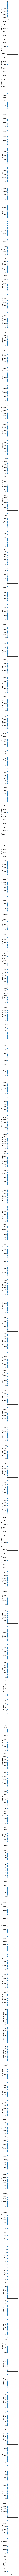

In [28]:
# Visualizing the Data

sns.pairplot(high_value_customers, x_vars=['churn'], y_vars=high_value_customers.select_dtypes(include=[np.number]).columns)
plt.show()

In [29]:
# Based on the above plot, the columns -'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 
# 'loc_ic_t2o_mou', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 
# 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7' and 'std_ic_t2o_mou_6' have no variation 

high_value_customers[['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 
                      'loc_ic_t2o_mou', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 
                      'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']].describe()

circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
count    28455.0         28455.0         28455.0         28455.0   
mean       109.0             0.0             0.0             0.0   
std          0.0             0.0             0.0             0.0   
min        109.0             0.0             0.0             0.0   
25%        109.0             0.0             0.0             0.0   
50%        109.0             0.0             0.0             0.0   
75%        109.0             0.0             0.0             0.0   
max        109.0             0.0             0.0             0.0   

       std_og_t2c_mou_6  std_og_t2c_mou_7  std_og_t2c_mou_8  std_ic_t2o_mou_6  \
count           28455.0           28455.0           28455.0           28455.0   
mean                0.0               0.0               0.0               0.0   
std                 0.0               0.0               0.0               0.0   
min                 0.0               0.0               0.0               0.0   
25%                 0.0               0.0               0.0               0.0   
50%                 0.0               0.0               0.0               0.0   
75%                 0.0               0.0               0.0               0.0   
max                 0.0               0.0               0.0               0.0   

       std_ic_t2o_mou_7  std_ic_t2o_mou_8  
count           28455.0           28455.0  
mean                0.0               0.0  
std                 0.0               0.0  
min                 0.0               0.0  
25%                 0.0               0.0  
50%                 0.0               0.0  
75%                 0.0               0.0  
max                 0.0               0.0

In [30]:
# Dropping circle_id
high_value_customers = high_value_customers.drop(['circle_id'], axis=1)

In [31]:
# Dropping loc_og_t2o_mou, std_og_t2o_mou and loc_ic_t2o_mou
high_value_customers = high_value_customers.drop(['loc_og_t2o_mou', 'std_og_t2o_mou','loc_ic_t2o_mou'], axis=1)

In [32]:
# Dropping std_og_t2c_mou_6	std_og_t2c_mou_7, std_og_t2c_mou_8, std_ic_t2o_mou_6,
# std_ic_t2o_mou_7, std_ic_t2o_mou_8 since the data for all the 3 months (6,7,8) is empty

high_value_customers = high_value_customers.drop(['std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 
                      'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8'], axis=1)

In [33]:
high_value_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28455 entries, 7 to 99997
Columns: 131 entries, mobile_number to churn
dtypes: float64(101), int64(30)
memory usage: 28.7 MB


We are now left with 131 columns.

In [34]:
pd.options.display.max_columns = None
high_value_customers.head()

mobile_number    arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  \
7      7000701601  1069.180  1349.850  3171.480        57.84        54.68   
8      7001524846   378.721   492.223   137.362       413.69       351.03   
13     7002191713   492.846   205.671   593.260       501.76       108.39   
16     7000875565   430.975   299.869   187.894        50.51        74.01   
17     7000187447   690.008    18.980    25.499      1185.91         9.28   

    onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  \
7         52.29        453.43        567.16        325.91          16.23   
8         35.08         94.66         80.63        136.48           0.00   
13       534.24        413.31        119.28        482.46          23.53   
16        70.61        296.29        229.74        162.76           0.00   
17         7.79         61.64          0.00          5.54           0.00   

    roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
7           33.49          31.64          23.74          12.59          38.06   
8            0.00           0.00           0.00           0.00           0.00   
13         144.24          72.11           7.98          35.26           1.44   
16           2.83           0.00           0.00          17.74           0.00   
17           4.76           4.81           0.00           8.46          13.34   

    loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
7              51.39             31.38             40.28            308.63   
8             297.13            217.59             12.49             80.96   
13             49.63              6.19             36.01            151.13   
16             42.61             65.16             67.38            273.29   
17             38.99              0.00              0.00             58.54   

    loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
7             447.38            162.28             62.13             55.14   
8              70.58             50.54              0.00              0.00   
13             47.28            294.46              4.54              0.00   
16            145.99            128.28              0.00              4.48   
17              0.00              0.00              0.00              0.00   

    loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
7              53.23               0.0               0.0              0.00   
8               0.00               0.0               0.0              7.15   
13             23.51               0.0               0.0              0.49   
16             10.26               0.0               0.0              0.00   
17              0.00               0.0               0.0              0.00   

    loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
7         422.16        533.91        255.79              4.30   
8         378.09        288.18         63.04            116.56   
13        205.31         53.48        353.99            446.41   
16        315.91        215.64        205.93              7.89   
17         97.54          0.00          0.00           1146.91   

    std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
7              23.29             12.01             49.89             31.76   
8             133.43             22.58             13.69             10.04   
13             85.98            498.23            255.36             52.94   
16              2.58              3.23             22.99             64.51   
17              0.81              0.00              1.55              0.00   

    std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
7              49.14              6.66             20.08             16.68   
8              75.69              0.00              0.00              0.00   
13            156.94              0.00              0.00              0.00   
16          

In [35]:
# Saving the cleaned dataset for analysis and building of model number 2
high_value_customers_2 = high_value_customers

## Building the Model for Prediction. This step includes
1. Preparing the data-set for building the model.
2. Analysing multicollinearity and outliers and taking necessary steps.
3. Perfroming scaling on the data-set
4. Building the model by tuning the hyperparameters and evaluating this model
5. Performing SMOTE to handle class-imbalance
6. Performing PCA
7. Building another model after PCA and evaluating this model
8. Conclusion 

### Dropping the specific outgoing and incoming
The total column should be sufficient indicator of the customer behavior, dropping the specific outgoing and incoming columns

In [36]:
lst_locogCol = list(high_value_customers.filter(regex='loc_og_'))
df_locogCol = pd.DataFrame(data=lst_locogCol)
#df_locogCol

high_value_customers = high_value_customers[high_value_customers.columns.drop(list(high_value_customers
                                                                                   .filter(regex='loc_og_')))]
high_value_customers = high_value_customers[high_value_customers.columns.drop(list(high_value_customers
                                                                                   .filter(regex='std_og_')))]
high_value_customers = high_value_customers[high_value_customers.columns.drop(list(high_value_customers
                                                                                   .filter(regex='isd_og_')))]
high_value_customers = high_value_customers[high_value_customers.columns.drop(list(high_value_customers
                                                                                   .filter(regex='spl_og_')))]
high_value_customers = high_value_customers[high_value_customers.columns.drop(list(high_value_customers
                                                                                   .filter(regex='og_others')))]
high_value_customers = high_value_customers[high_value_customers.columns.drop(list(high_value_customers
                                                                                   .filter(regex='roam_og_')))]
#high_value_customers = high_value_customers[high_value_customers.columns.drop(list(high_value_customers
 #                                                                                  .filter(regex='total_og_')))]




high_value_customers.head() 

mobile_number    arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  \
7      7000701601  1069.180  1349.850  3171.480        57.84        54.68   
8      7001524846   378.721   492.223   137.362       413.69       351.03   
13     7002191713   492.846   205.671   593.260       501.76       108.39   
16     7000875565   430.975   299.869   187.894        50.51        74.01   
17     7000187447   690.008    18.980    25.499      1185.91         9.28   

    onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  \
7         52.29        453.43        567.16        325.91          16.23   
8         35.08         94.66         80.63        136.48           0.00   
13       534.24        413.31        119.28        482.46          23.53   
16        70.61        296.29        229.74        162.76           0.00   
17         7.79         61.64          0.00          5.54           0.00   

    roam_ic_mou_7  roam_ic_mou_8  total_og_mou_6  total_og_mou_7  \
7           33.49          31.64          487.53          609.24   
8            0.00           0.00          508.36          431.66   
13         144.24          72.11          907.09          192.41   
16           2.83           0.00          346.81          286.01   
17           4.76           4.81         1249.53            0.81   

    total_og_mou_8  loc_ic_t2t_mou_6  loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  \
7           350.16             58.14             32.26             27.31   
8           171.56             23.84              9.84              0.31   
13         1015.26             67.88              7.58             52.58   
16          233.38             41.33             71.44             28.89   
17            0.00             34.54              0.00              0.00   

    loc_ic_t2m_mou_6  loc_ic_t2m_mou_7  loc_ic_t2m_mou_8  loc_ic_t2f_mou_6  \
7             217.56            221.49            121.19            152.16   
8              57.58             13.98             15.48              0.00   
13            142.88             18.53            195.18              4.81   
16            226.81            149.69            150.16              8.71   
17             47.41              2.31              0.00              0.00   

    loc_ic_t2f_mou_7  loc_ic_t2f_mou_8  loc_ic_mou_6  loc_ic_mou_7  \
7             101.46             39.53        427.88        355.23   
8               0.00              0.00         81.43         23.83   
13              0.00              7.49        215.58         26.11   
16              8.68             32.71        276.86        229.83   
17              0.00              0.00         81.96          2.31   

    loc_ic_mou_8  std_ic_t2t_mou_6  std_ic_t2t_mou_7  std_ic_t2t_mou_8  \
7         188.04             36.89             11.83             30.39   
8          15.79              0.00              0.58              0.10   
13        255.26            115.68             38.29            154.58   
16        211.78             68.79             78.64              6.33   
17          0.00              8.63              0.00              0.00   

    std_ic_t2m_mou_6  std_ic_t2m_mou_7  std_ic_t2m_mou_8  std_ic_t2f_mou_6  \
7              91.44            126.99            141.33             52.19   
8              22.43              4.08              0.65              0.00   
13            308.13             29.79            317.91              0.00   
16             18.68             73.08             73.93              0.51   
17              1.28              0.00              0.00              0.00   

    std_ic_t2f_mou_7  std_ic_t2f_mou_8  std_ic_mou_6  std_ic_mou_7  \
7              34.24             22.21        180.54        173.08   
8               0.00              0.00         22.43          4.66   
13              0.00              1.91        423.81         68.09   
16              0.00              2.18         87.99        151.73   
17              0.00              0.00          9.91          0.

In [37]:
high_value_customers = high_value_customers[high_value_customers.columns.drop(list(high_value_customers
                                                                                   .filter(regex='loc_ic_')))]
high_value_customers = high_value_customers[high_value_customers.columns.drop(list(high_value_customers
                                                                                   .filter(regex='std_ic_')))]
high_value_customers = high_value_customers[high_value_customers.columns.drop(list(high_value_customers
                                                                                   .filter(regex='ic_others')))]
high_value_customers = high_value_customers[high_value_customers.columns.drop(list(high_value_customers
                                                                                   .filter(regex='spl_ic_')))]
high_value_customers = high_value_customers[high_value_customers.columns.drop(list(high_value_customers
                                                                                   .filter(regex='isd_ic_')))]
high_value_customers = high_value_customers[high_value_customers.columns.drop(list(high_value_customers
                                                                                   .filter(regex='roam_ic_')))]
#high_value_customers = high_value_customers[high_value_customers.columns.drop(list(high_value_customers
 #                                                                                  .filter(regex='total_ic_')))]
    
high_value_customers = high_value_customers[high_value_customers.columns.drop(list(high_value_customers
                                                                                   .filter(regex='onnet_mou_')))]
high_value_customers = high_value_customers[high_value_customers.columns.drop(list(high_value_customers
                                                                                   .filter(regex='offnet_mou_')))]

high_value_customers.head() 

mobile_number    arpu_6    arpu_7    arpu_8  total_og_mou_6  \
7      7000701601  1069.180  1349.850  3171.480          487.53   
8      7001524846   378.721   492.223   137.362          508.36   
13     7002191713   492.846   205.671   593.260          907.09   
16     7000875565   430.975   299.869   187.894          346.81   
17     7000187447   690.008    18.980    25.499         1249.53   

    total_og_mou_7  total_og_mou_8  total_ic_mou_6  total_ic_mou_7  \
7           609.24          350.16          626.46          558.04   
8           431.66          171.56          103.86           28.49   
13          192.41         1015.26          968.61          172.58   
16          286.01          233.38          364.86          381.56   
17            0.81            0.00           91.88            2.31   

    total_ic_mou_8  total_rech_num_6  total_rech_num_7  total_rech_num_8  \
7           428.74                 5                 5                 7   
8            16.54                19                21                14   
13         1144.53                 6                 4                11   
16          294.46                10                 6                 2   
17            0.00                19                 2                 4   

    total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  max_rech_amt_6  \
7               1580               790              3638            1580   
8                437               601               120              90   
13               507               253               717             110   
16               570               348               160             110   
17               816                 0                30             110   

    max_rech_amt_7  max_rech_amt_8  date_of_last_rech_6  date_of_last_rech_7  \
7              790            1580                   27                   25   
8              154              30                   25                   31   
13             110             130                   20                   22   
16             110             130                   30                   31   
17               0              30                   30                   30   

    date_of_last_rech_8  last_day_rch_amt_6  last_day_rch_amt_7  \
7                    26                   0                   0   
8                    30                  50                   0   
13                   30                 110                  50   
16                   14                 100                 100   
17                   25                  30                   0   

    last_day_rch_amt_8  vol_2g_mb_6  vol_2g_mb_7  vol_2g_mb_8  vol_3g_mb_6  \
7                  779          0.0          0.0         0.00          0.0   
8                   10          0.0        356.0         0.03          0.0   
13                   0          0.0          0.0         0.02          0.0   
16                 130          0.0          0.0         0.00          0.0   
17                   0          0.0          0.0         0.00          0.0   

    vol_3g_mb_7  vol_3g_mb_8  monthly_2g_6  monthly_2g_7  monthly_2g_8  \
7          0.00         0.00             0             0             0   
8        750.95        11.94             0             1             0   
13         0.00         0.00             0             0             0   
16         0.00         0.00             0             0             0   
17         0.00         0.00             0             0             0   

    sachet_2g_6  sachet_2g_7  sachet_2g_8  monthly_3g_6  monthly_3g_7  \
7             0            0            0             0             0   
8             0            1            3             0             0   
13            0            0            3             0             0   
16            0            0            0             0             0   
17            0            0            0             0             0   

    monthly_3g_8  sachet_3g_6

In [38]:
#Dropping the sept(month 9) data coming in different format
high_value_customers = high_value_customers[high_value_customers.columns.drop(list(high_value_customers
                                                                                   .filter(regex='sep_vbc_3g')))]


In [39]:
high_value_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28455 entries, 7 to 99997
Data columns (total 49 columns):
mobile_number          28455 non-null int64
arpu_6                 28455 non-null float64
arpu_7                 28455 non-null float64
arpu_8                 28455 non-null float64
total_og_mou_6         28455 non-null float64
total_og_mou_7         28455 non-null float64
total_og_mou_8         28455 non-null float64
total_ic_mou_6         28455 non-null float64
total_ic_mou_7         28455 non-null float64
total_ic_mou_8         28455 non-null float64
total_rech_num_6       28455 non-null int64
total_rech_num_7       28455 non-null int64
total_rech_num_8       28455 non-null int64
total_rech_amt_6       28455 non-null int64
total_rech_amt_7       28455 non-null int64
total_rech_amt_8       28455 non-null int64
max_rech_amt_6         28455 non-null int64
max_rech_amt_7         28455 non-null int64
max_rech_amt_8         28455 non-null int64
date_of_last_rech_6    28455 non-null

### Checking for Outliers

In [40]:
high_value_customers.describe(percentiles=[.25,.5,.75,.90,.95,.99])

mobile_number        arpu_6        arpu_7        arpu_8  \
count   2.845500e+04  28455.000000  28455.000000  28455.000000   
mean    7.001227e+09    585.222943    597.457377    551.837418   
std     6.815803e+05    430.159368    461.389081    488.581938   
min     7.000000e+09   -810.661000   -622.509000   -345.129000   
25%     7.000649e+09    365.016500    372.011500    308.683500   
50%     7.001238e+09    493.567000    498.340000    464.001000   
75%     7.001814e+09    697.916000    705.000000    681.996500   
90%     7.002166e+09    984.971000    999.851000    993.461200   
95%     7.002287e+09   1230.079700   1263.787100   1266.684500   
99%     7.002386e+09   1951.665820   1996.740380   1987.412560   
max     7.002411e+09  27731.088000  35145.834000  33543.624000   

       total_og_mou_6  total_og_mou_7  total_og_mou_8  total_ic_mou_6  \
count    28455.000000    28455.000000    28455.000000    28455.000000   
mean       688.433830      723.642176      646.690991      311.688812   
std        649.963941      681.246023      680.352660      357.663653   
min          0.000000        0.000000        0.000000        0.000000   
25%        275.450000      291.325000      217.000000       94.035000   
50%        514.810000      540.060000      459.510000      209.810000   
75%        894.415000      944.760000      854.225000      398.510000   
90%       1450.130000     1505.014000     1412.930000      688.672000   
95%       1903.880000     1967.584000     1892.334000      937.430000   
99%       3146.462000     3303.975000     3251.367000     1735.704800   
max      10674.030000    11365.310000    14043.060000     6798.640000   

       total_ic_mou_7  total_ic_mou_8  total_rech_num_6  total_rech_num_7  \
count    28455.000000    28455.000000      28455.000000      28455.000000   
mean       323.839167      307.813320         12.172026         12.153892   
std        373.177770      364.108211          9.386361          9.604631   
min          0.000000        0.000000          1.000000          1.000000   
25%        105.600000       89.810000          6.000000          6.000000   
50%        218.860000      203.760000         10.000000          9.000000   
75%        405.710000      392.235000         15.000000         15.000000   
90%        699.772000      682.552000         23.000000         24.000000   
95%        957.368000      949.635000         30.000000         30.000000   
99%       1836.800000     1774.035000         47.000000         48.000000   
max       7279.080000     5990.710000        307.000000        138.000000   

       total_rech_num_8  total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  \
count      28455.000000      28455.000000      28455.000000      28455.000000   
mean          10.622597        693.875734        704.529432        636.596661   
std            9.467323        526.520232        559.703049        597.813646   
min            1.000000          0.000000          0.000000          0.000000   
25%            5.000000        433.000000        435.000000        338.000000   
50%            8.000000        580.000000        586.000000        535.000000   
75%           13.000000        829.000000        837.000000        801.000000   
90%           22.000000       1169.000000       1196.000000       1170.000000   
95%           29.000000       1458.300000       1510.000000       1501.300000   
99%           46.000000       2342.920000       2424.380000       2346.220000   
max          196.000000      35190.000000      40335.000000      45320.000000   

       max_rech_amt_6  max_rech_amt_7  max_rech_amt_8  date_of_last_rech_6  \
count     28455.00000    28455.000000    28455.000000          28455.00000   
mean        167.65760      172.878721      167.220348             26.95340   
std         162.80806      170.012307      167.974466              4.04801   
min           0.00000        0.000000        0.000000              1.00000   
25%         110.00000      110.000000       98.00

## Scaling data using Normalization

In [41]:
min_max_scaler = preprocessing.MinMaxScaler()
cols = high_value_customers.columns
hvc_scaled = min_max_scaler.fit_transform(high_value_customers)
hvc_normalized = pd.DataFrame(hvc_scaled, columns = cols)
hvc_normalized.head()

mobile_number    arpu_6    arpu_7    arpu_8  total_og_mou_6  \
0       0.290990  0.065863  0.055143  0.103769        0.045674   
1       0.632467  0.041672  0.031165  0.014237        0.047626   
2       0.909080  0.045670  0.023154  0.027690        0.084981   
3       0.363149  0.043502  0.025788  0.015729        0.032491   
4       0.077721  0.052578  0.017935  0.010937        0.117063   

   total_og_mou_7  total_og_mou_8  total_ic_mou_6  total_ic_mou_7  \
0        0.053605        0.024935        0.092145        0.076664   
1        0.037980        0.012217        0.015277        0.003914   
2        0.016930        0.072296        0.142471        0.023709   
3        0.025165        0.016619        0.053667        0.052419   
4        0.000071        0.000000        0.013514        0.000317   

   total_ic_mou_8  total_rech_num_6  total_rech_num_7  total_rech_num_8  \
0        0.071567          0.013072          0.029197          0.030769   
1        0.002761          0.058824          0.145985          0.066667   
2        0.191051          0.016340          0.021898          0.051282   
3        0.049153          0.029412          0.036496          0.005128   
4        0.000000          0.058824          0.007299          0.015385   

   total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  max_rech_amt_6  \
0          0.044899          0.019586          0.080274        0.443945   
1          0.012418          0.014900          0.002648        0.025288   
2          0.014408          0.006272          0.015821        0.030908   
3          0.016198          0.008628          0.003530        0.030908   
4          0.023188          0.000000          0.000662        0.030908   

   max_rech_amt_7  max_rech_amt_8  date_of_last_rech_6  date_of_last_rech_7  \
0        0.239467        0.355136             0.896552             0.800000   
1        0.046681        0.006743             0.827586             1.000000   
2        0.033343        0.029220             0.655172             0.700000   
3        0.033343        0.029220             1.000000             1.000000   
4        0.000000        0.006743             1.000000             0.966667   

   date_of_last_rech_8  last_day_rch_amt_6  last_day_rch_amt_7  \
0             0.833333            0.000000            0.000000   
1             0.966667            0.015156            0.000000   
2             0.966667            0.033343            0.016129   
3             0.433333            0.030312            0.032258   
4             0.800000            0.009094            0.000000   

   last_day_rch_amt_8  vol_2g_mb_6  vol_2g_mb_7  vol_2g_mb_8  vol_3g_mb_6  \
0            0.175096          0.0     0.000000     0.000000          0.0   
1            0.002248          0.0     0.045215     0.000003          0.0   
2            0.000000          0.0     0.000000     0.000002          0.0   
3            0.029220          0.0     0.000000     0.000000          0.0   
4            0.000000          0.0     0.000000     0.000000          0.0   

   vol_3g_mb_7  vol_3g_mb_8  monthly_2g_6  monthly_2g_7  monthly_2g_8  \
0     0.000000     0.000000           0.0           0.0           0.0   
1     0.026682     0.000403           0.0           0.2           0.0   
2     0.000000     0.000000           0.0           0.0           0.0   
3     0.000000     0.000000           0.0           0.0           0.0   
4     0.000000     0.000000           0.0           0.0           0.0   

   sachet_2g_6  sachet_2g_7  sachet_2g_8  monthly_3g_6  monthly_3g_7  \
0          0.0     0.000000     0.000000           0.0           0.0   
1          0.0     0.020833     0.068182           0.0           0.0   
2          0.0     0.000000     0.068182           0.0           0.0   
3          0.0     0.000000     0.000000           0.0           0.0   
4          0.0     0.000000     0.000000           0.0           0.0   

   monthly_3g_8  sachet_3g_6  sachet_3g_7  sachet_3g_8       aon  aug_vbc_3g  \
0 

In [42]:
churn = (sum(hvc_normalized['churn'])/len(hvc_normalized['churn'].index))*100
churn

7.496046389035318

## Collinearity

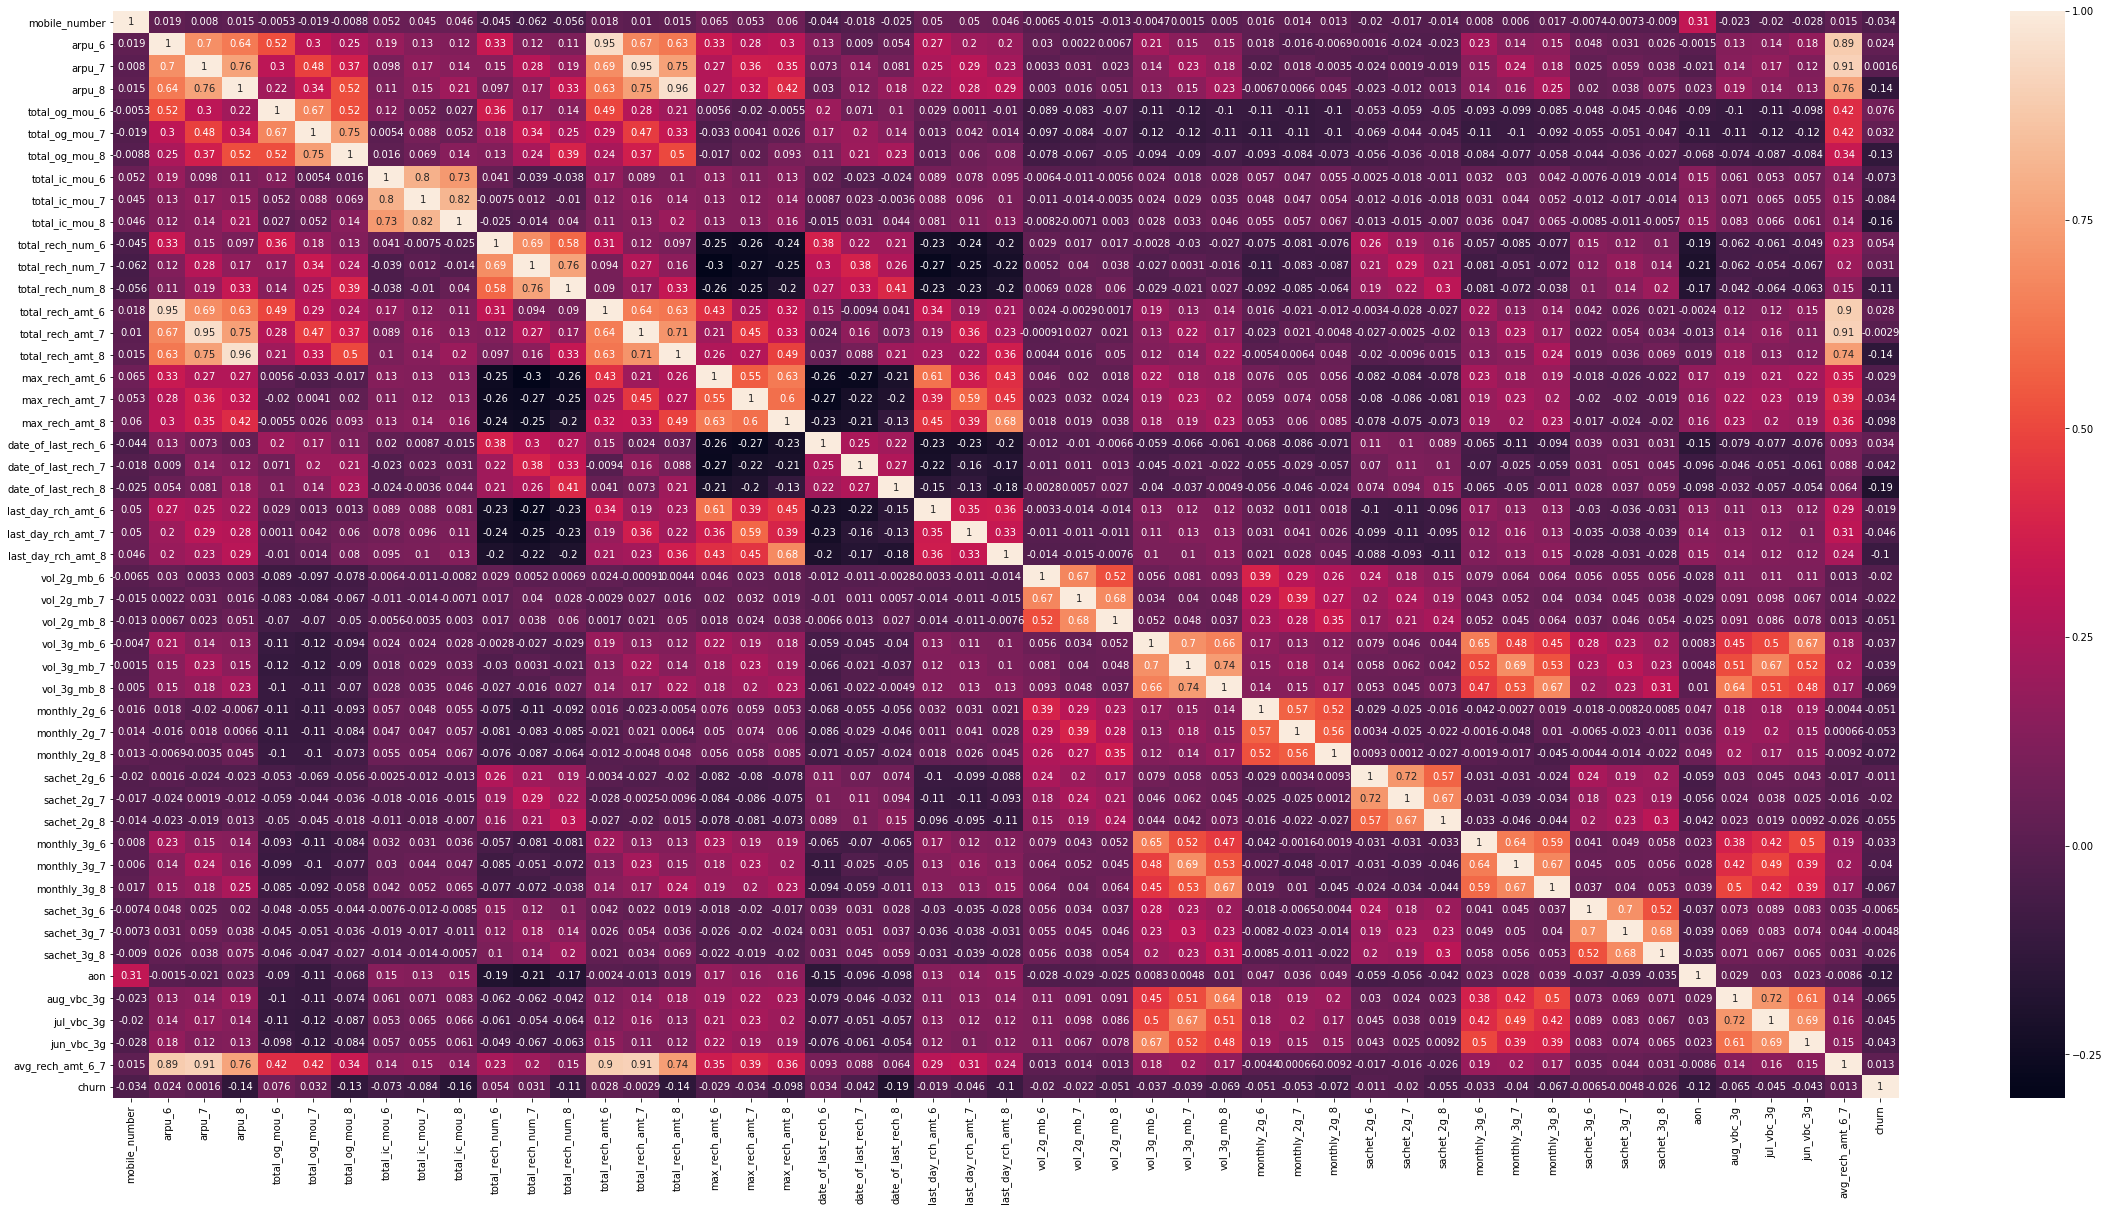

In [43]:
# Build the correlation matrix 
plt.figure(figsize = (40,20))        # Size of the figure
sns.heatmap(hvc_normalized.corr(),annot = True)

In [44]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

In [45]:
def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [46]:
get_top_abs_correlations(hvc_normalized, 20)

arpu_8            total_rech_amt_8    0.959858
arpu_6            total_rech_amt_6    0.951698
arpu_7            total_rech_amt_7    0.951141
                  avg_rech_amt_6_7    0.912090
total_rech_amt_7  avg_rech_amt_6_7    0.911910
total_rech_amt_6  avg_rech_amt_6_7    0.899823
arpu_6            avg_rech_amt_6_7    0.891903
total_ic_mou_7    total_ic_mou_8      0.817583
total_ic_mou_6    total_ic_mou_7      0.803740
arpu_8            avg_rech_amt_6_7    0.763659
arpu_7            arpu_8              0.760706
total_rech_num_7  total_rech_num_8    0.759996
arpu_7            total_rech_amt_8    0.751077
arpu_8            total_rech_amt_7    0.750640
total_og_mou_7    total_og_mou_8      0.745383
total_rech_amt_8  avg_rech_amt_6_7    0.741995
vol_3g_mb_7       vol_3g_mb_8         0.736256
total_ic_mou_6    total_ic_mou_8      0.727312
sachet_2g_6       sachet_2g_7         0.718949
aug_vbc_3g        jul_vbc_3g          0.718434
dtype: float64

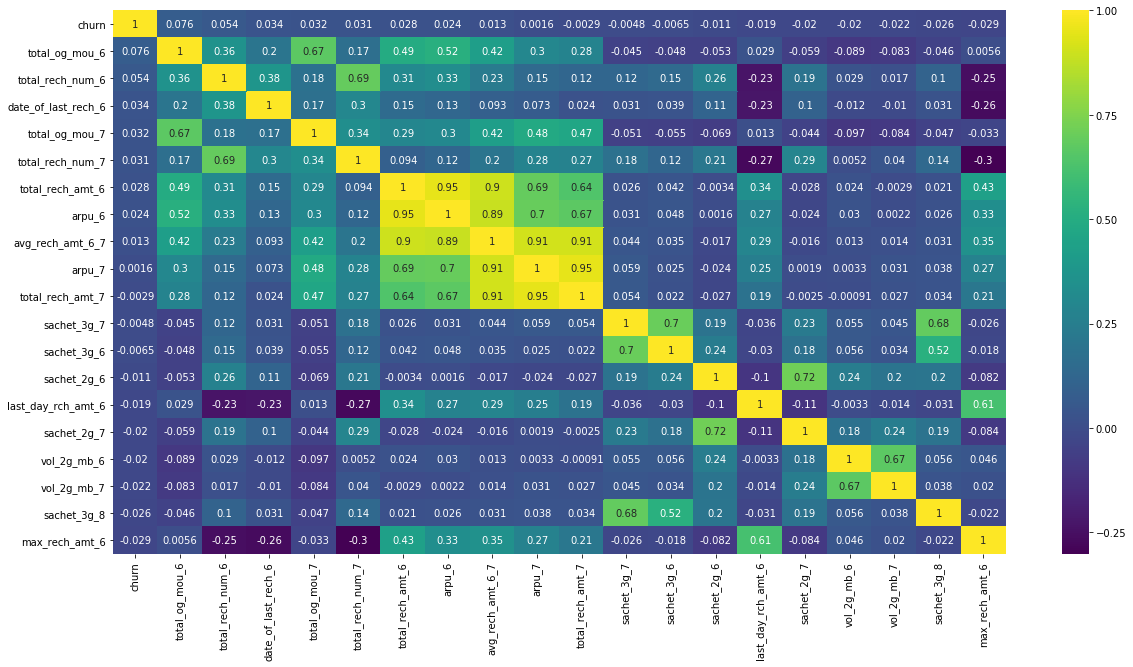

In [47]:
k = 20 #number of variables for heatmap
result="churn"
#cols = X_train.corr().nlargest(k, result)[result].index
cols = hvc_normalized.corr().nlargest(k,"churn")["churn"].index
plt.figure(figsize=(20,10))
sns.heatmap(hvc_normalized[cols].corr(), annot=True, cmap = 'viridis')

In [48]:
#dropping the columns with very high multi-collinearity
hvc_normalized_nonCollinear = pd.DataFrame(hvc_normalized).drop(['avg_rech_amt_6_7','total_ic_mou_6','total_ic_mou_7', 'total_ic_mou_8','total_og_mou_6','total_og_mou_7','total_og_mou_8'],1)


In [49]:
hvc_normalized_nonCollinear.shape

(28455, 42)

In [50]:
hvc_normalized_nonCollinear.head()

mobile_number    arpu_6    arpu_7    arpu_8  total_rech_num_6  \
0       0.290990  0.065863  0.055143  0.103769          0.013072   
1       0.632467  0.041672  0.031165  0.014237          0.058824   
2       0.909080  0.045670  0.023154  0.027690          0.016340   
3       0.363149  0.043502  0.025788  0.015729          0.029412   
4       0.077721  0.052578  0.017935  0.010937          0.058824   

   total_rech_num_7  total_rech_num_8  total_rech_amt_6  total_rech_amt_7  \
0          0.029197          0.030769          0.044899          0.019586   
1          0.145985          0.066667          0.012418          0.014900   
2          0.021898          0.051282          0.014408          0.006272   
3          0.036496          0.005128          0.016198          0.008628   
4          0.007299          0.015385          0.023188          0.000000   

   total_rech_amt_8  max_rech_amt_6  max_rech_amt_7  max_rech_amt_8  \
0          0.080274        0.443945        0.239467        0.355136   
1          0.002648        0.025288        0.046681        0.006743   
2          0.015821        0.030908        0.033343        0.029220   
3          0.003530        0.030908        0.033343        0.029220   
4          0.000662        0.030908        0.000000        0.006743   

   date_of_last_rech_6  date_of_last_rech_7  date_of_last_rech_8  \
0             0.896552             0.800000             0.833333   
1             0.827586             1.000000             0.966667   
2             0.655172             0.700000             0.966667   
3             1.000000             1.000000             0.433333   
4             1.000000             0.966667             0.800000   

   last_day_rch_amt_6  last_day_rch_amt_7  last_day_rch_amt_8  vol_2g_mb_6  \
0            0.000000            0.000000            0.175096          0.0   
1            0.015156            0.000000            0.002248          0.0   
2            0.033343            0.016129            0.000000          0.0   
3            0.030312            0.032258            0.029220          0.0   
4            0.009094            0.000000            0.000000          0.0   

   vol_2g_mb_7  vol_2g_mb_8  vol_3g_mb_6  vol_3g_mb_7  vol_3g_mb_8  \
0     0.000000     0.000000          0.0     0.000000     0.000000   
1     0.045215     0.000003          0.0     0.026682     0.000403   
2     0.000000     0.000002          0.0     0.000000     0.000000   
3     0.000000     0.000000          0.0     0.000000     0.000000   
4     0.000000     0.000000          0.0     0.000000     0.000000   

   monthly_2g_6  monthly_2g_7  monthly_2g_8  sachet_2g_6  sachet_2g_7  \
0           0.0           0.0           0.0          0.0     0.000000   
1           0.0           0.2           0.0          0.0     0.020833   
2           0.0           0.0           0.0          0.0     0.000000   
3           0.0           0.0           0.0          0.0     0.000000   
4           0.0           0.0           0.0          0.0     0.000000   

   sachet_2g_8  monthly_3g_6  monthly_3g_7  monthly_3g_8  sachet_3g_6  \
0     0.000000           0.0           0.0           0.0          0.0   
1     0.068182           0.0           0.0           0.0          0.0   
2     0.068182           0.0           0.0           0.0          0.0   
3     0.000000           0.0           0.0           0.0          0.0   
4     0.000000           0.0           0.0           0.0          0.0   

   sachet_3g_7  sachet_3g_8       aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  \
0          0.0          0.0  0.150205    0.004470    0.002114    0.001678   
1          0.0          0.0  0.032601    0.001628    0.099355    0.010940   
2          0.0          0.0  0.586090    0.000000    0.000000    0.000000   
3          0.0          0.0  0.079932    0.000000    0.000267    0.001960   
4          0.0          0.0  0.117604    0.000000    0.000000    0.000000   

   churn  
0    1.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0

## Model Building

In [51]:
# Putting feature variable to X
X = hvc_normalized_nonCollinear.drop(['churn','mobile_number'],axis=1)

# Putting response variable to y
y = hvc_normalized_nonCollinear['churn']

y.head()

0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: churn, dtype: float64

In [52]:
print(X.shape)

(28455, 40)


In [53]:
#Test on class imbalance - The following snippet is Not in use
clf = RandomForestClassifier()
clf.fit(X,y)
y_pred_b = clf.predict(X)
np.unique(y_pred_b)
print(y_pred_b)
accuracy_score(y, y_pred_b)
prob_y = clf.predict_proba(X)
prob_y = [p[1] for p in prob_y]
roc_auc_score(y, prob_y)

[1. 0. 0. ... 0. 0. 0.]


0.9997354074977453

### Splitting the data into train and test

In [54]:
X_train_init, X_test_init, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

In [55]:
print(X_train_init.shape)
print(X_test_init.shape)
print(y_train.shape)
print(y_test.shape)
print(type(X_train_init))
print(type(X_train_init))
print(type(y_train))
print(type(y_test))

(19918, 40)
(8537, 40)
(19918,)
(8537,)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


#### Custom function to generate accuracy score

In [56]:
def generate_accuracy(model, x, y):
#     cm = confusion_matrix(y,model.predict(x))
#     sns.heatmap(cm,annot=True,fmt="d")
    ac = accuracy_score(y,model.predict(x))
    f_score = f1_score(y,model.predict(x))
    print('Accuracy is: ', ac)
    print('F1 score is: ', f_score)    
    return 1

### Checking for class imbalance on target variable

In [57]:
churn_count = hvc_normalized_nonCollinear.churn.value_counts()
print(churn_count[0])
print(churn_count[1])

26322
2133


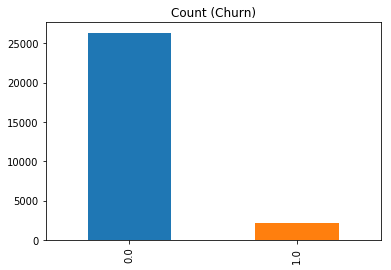

In [58]:
#plotting the bar chart to look for imbalance in the target variable
churn_count.plot(kind='bar', title='Count (Churn)')

#### It's evident that there's a class imbalance in the churn data in the given dataset

In [59]:
#Custom function to plot a graph(taken from internet)
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

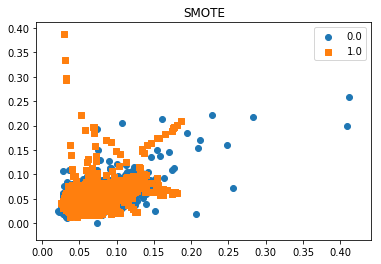

In [60]:
smote = SMOTE(ratio='minority')
X_train_smt, y_train_smt = smote.fit_sample(X_train_init, y_train.ravel())
plot_2d_space(X_train_smt, y_train_smt, 'SMOTE')



In [61]:
#Test with SMOTE Tomek, seems to be expensive for the given dataset
#smt = SMOTETomek(ratio='auto')
#X_smt, y_smt = smt.fit_sample(X, y)

#plot_2d_space(X_smt, y_smt, 'SMOTETomek')

In [63]:
clf_lr0 = LogisticRegression()
bm = clf_lr0.fit(X_train_smt, y_train_smt)
generate_accuracy(bm, X_train_smt, y_train_smt)


Accuracy is:  0.7763107851127411
F1 score is:  0.776189181842892


1

In [64]:
y_train_smt.ravel().shape

(36810,)

In [65]:
#printing the shapes and types of current & previous train and test dataset and observing the differences
print(X_train_smt.shape)
print(y_train_smt.shape)
print(X_train_init.shape)
print(X_test_init.shape)
print(y_train.shape)
print(y_test.shape)
print(type(X_train_smt))
print(type(X_train_smt.ravel()))
print(type(X_test_init))
print(type(y_train_smt))
print(type(y_test))

(36810, 40)
(36810,)
(19918, 40)
(8537, 40)
(19918,)
(8537,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [66]:
y_train.head()

26626    0.0
17019    0.0
6900     0.0
16169    0.0
22695    0.0
Name: churn, dtype: float64

In [67]:
X_train = pd.DataFrame(X_train_smt, columns = X_test_init.columns)
#X_smt = pd.DataFrame(data=X_train_smt, columns = X_test_init.columns )
y_train = pd.DataFrame(y_train_smt)
X_test = X_test_init.copy(deep=False)

In [68]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(36810, 40)
(36810, 1)
(8537, 40)
(8537,)


### Executing the model

In [69]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      0   No. Observations:                36810
Model:                            GLM   Df Residuals:                    36769
Model Family:                Binomial   Df Model:                           40
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17961.
Date:                Mon, 07 Oct 2019   Deviance:                       35921.
Time:                        20:20:39   Pearson chi2:                 1.11e+06
No. Iterations:                     6   Covariance Type:             nonrobust
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   4.0200      0.234     17.215      0.000       3.562       4.478
arpu_6                -13.1343      3.969     -3.309      0.001     -20.913      -5.355
arpu_7                 48.5016      6.043      8.026      0.000      36.658      60.345
arpu_8                -53.7846      5.771     -9.320      0.000     -65.096     -42.474
total_rech_num_6       -4.1070      0.855     -4.801      0.000      -5.784      -2.430
total_rech_num_7        5.1227      0.469     10.926      0.000       4.204       6.042
total_rech_num_8       -8.8779      0.719    -12.348      0.000     -10.287      -7.469
total_rech_amt_6       47.7337      4.478     10.660      0.000      38.957      56.510
total_rech_amt_7       -9.5279      6.051     -1.575      0.115     -21.387       2.331
total_rech_amt_8      -21.0766      6.911     -3.050      0.002     -34.622      -7.531
max_rech_amt_6         -3.9687      0.677     -5.862      0.000      -5.296      -2.642
max_rech_amt_7          1.0597      0.576      1.840      0.066      -0.069       2.188
max_rech_amt_8          5.9635      0.836      7.135      0.000       4.325       7.602
date_of_last_rech_6    -0.1981      0.118     -1.674      0.094      -0.430       0.034
date_of_last_rech_7    -0.2594      0.106     -2.441      0.015      -0.468      -0.051
date_of_last_rech_8    -3.4166      0.094    -36.170      0.000      -3.602      -3.231
last_day_rch_amt_6      0.1888      0.562      0.336      0.737      -0.912       1.290
last_day_rch_amt_7     -0.4264      0.522     -0.817      0.414      -1.449       0.596
last_day_rch_amt_8    -21.7751      0.839    -25.963      0.000     -23.419     -20.131
vol_2g_mb_6             3.7266      1.003      3.715      0.000       1.761       5.692
vol_2g_mb_7             0.4597      0.868      0.529      0.596      -1.242       2.161
vol_2g_mb_8            -7.3367      1.511     -4.854      0.000     -10.299      -4.375
vol_3g_mb_6             3.5411      1.483      2.388      0.017       0.635       6.447
vol_3g_mb_7             6.6193      1.508      4.389      0.000       3.663       9.576
vol_3g_mb_8            -7.8687      1.850     -4.254      0.000     -11.494      -4.244
monthly_2g_6           -2.6582      0.278     -9.555      0.000      -3.203      -2.113
monthly_2g_7           -2.3474      0.342     -6.872      0.000      -3.017      -1.678
monthly_2g_8           -4.4269      0.433    -10.230      0.000      -5.275      -3.579
sachet_2g_6             1.9780      0.564      3.509      0.000       0.873       3.083
sachet_2g_7            -3.1771      0.681     -4.664      0.000      -4.512      -1.842
sachet_2g_8            -7.1153      0.682    -10.429      0.000      -8.453      -5.778
monthly_3g_6           -2.8635      0.856     -3.345      0.001      -4.541      -1.186
monthly_3g_7           -3.3433      0.920     -3.632      0.000      -5.147      -

In [70]:
clf_lr1 = LogisticRegression()
bm = clf_lr1.fit(X_train, y_train)
generate_accuracy(bm, X_test, y_test)

Accuracy is:  0.7712311116317208
F1 score is:  0.324455205811138


1

In [71]:
pd.DataFrame(y_train).head(3)

0
0  0.0
1  0.0
2  0.0

### Building the correlation matrix again on train dataset

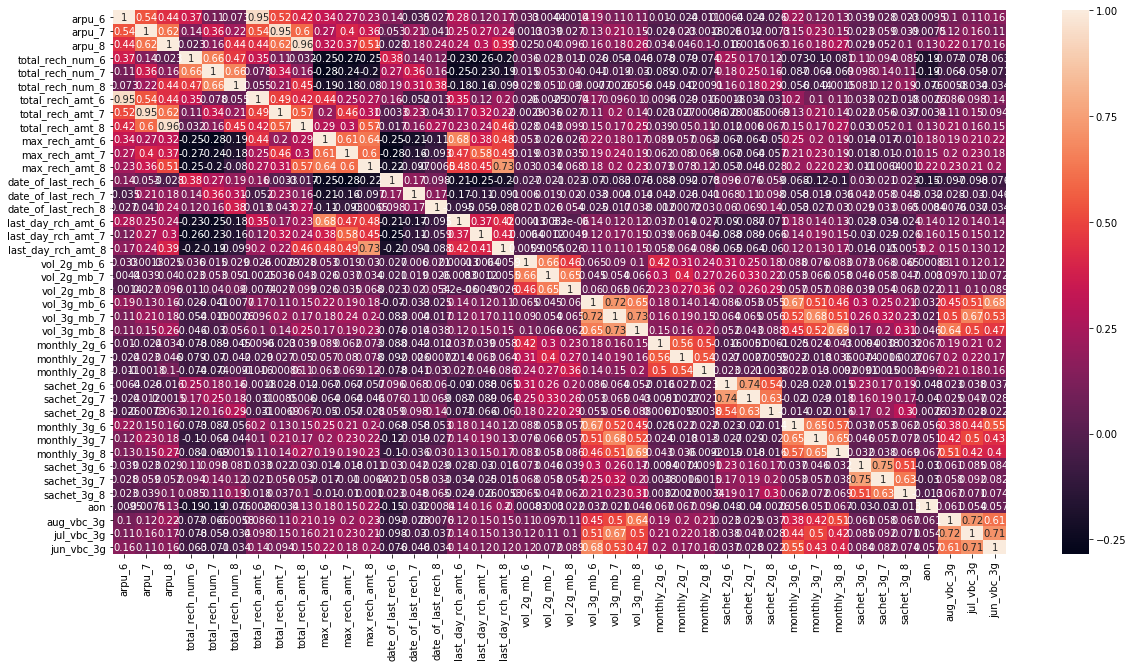

In [72]:
#building heatmap on current X train dataset
plt.figure(figsize = (20,10))
sns.heatmap(X_train.corr(),annot = True)

In [73]:
X_train.head()

arpu_6    arpu_7    arpu_8  total_rech_num_6  total_rech_num_7  \
0  0.037562  0.028367  0.030420          0.026144          0.043796   
1  0.037525  0.026102  0.018808          0.006536          0.029197   
2  0.041101  0.031915  0.025105          0.016340          0.036496   
3  0.042072  0.036401  0.022881          0.029412          0.094891   
4  0.044588  0.030915  0.019635          0.022876          0.051095   

   total_rech_num_8  total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  \
0          0.071795          0.018926          0.011578          0.013217   
1          0.015385          0.009378          0.010909          0.005737   
2          0.035897          0.014095          0.015024          0.014034   
3          0.056410          0.012390          0.019487          0.011143   
4          0.041026          0.014408          0.012818          0.009974   

   max_rech_amt_6  max_rech_amt_7  max_rech_amt_8  date_of_last_rech_6  \
0        0.168306        0.121249        0.089908             1.000000   
1        0.030908        0.033343        0.029220             0.793103   
2        0.033717        0.036375        0.029220             0.862069   
3        0.030908        0.046681        0.029220             0.827586   
4        0.030908        0.036375        0.029220             0.896552   

   date_of_last_rech_7  date_of_last_rech_8  last_day_rch_amt_6  \
0             0.900000             0.766667            0.000000   
1             0.900000             0.700000            0.033343   
2             0.966667             0.866667            0.036375   
3             0.866667             1.000000            0.009094   
4             0.866667             0.966667            0.033343   

   last_day_rch_amt_7  last_day_rch_amt_8  vol_2g_mb_6  vol_2g_mb_7  \
0            0.000000            0.000000     0.000012     0.000000   
1            0.035484            0.029220     0.000000     0.000000   
2            0.032258            0.029220     0.000000     0.000000   
3            0.016129            0.011238     0.000000     0.003258   
4            0.035484            0.008092     0.000000     0.000000   

   vol_2g_mb_8  vol_3g_mb_6  vol_3g_mb_7  vol_3g_mb_8  monthly_2g_6  \
0     0.000009          0.0     0.000000     0.004735           0.0   
1     0.000000          0.0     0.000000     0.000000           0.0   
2     0.000000          0.0     0.000000     0.000000           0.0   
3     0.004355          0.0     0.020366     0.003405           0.0   
4     0.000000          0.0     0.000000     0.000000           0.0   

   monthly_2g_7  monthly_2g_8  sachet_2g_6  sachet_2g_7  sachet_2g_8  \
0           0.0           0.2     0.102564       0.0625     0.113636   
1           0.0           0.0     0.000000       0.0000     0.000000   
2           0.0           0.0     0.000000       0.0000     0.000000   
3           0.2           0.0     0.000000       0.0000     0.022727   
4           0.0           0.0     0.000000       0.0000     0.000000   

   monthly_3g_6  monthly_3g_7  monthly_3g_8  sachet_3g_6  sachet_3g_7  \
0           0.0           0.0           0.0          0.0          0.0   
1           0.0           0.0           0.0          0.0          0.0   
2           0.0           0.0           0.0          0.0          0.0   
3           0.0           0.0           0.0          0.0          0.0   
4           0.0           0.0           0.0          0.0          0.0   

   sachet_3g_8       aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  
0      0.00000  0.138372    0.000000    0.000000         0.0  
1      0.00000  0.621589    0.000000    0.000000         0.0  
2      0.00000  0.170490    0.000000    0.000000         0.0  
3      0.02439  0.148756    0.000098    0.007235         0.0  
4      0.00000  0.029220    0.000000    0.000000         0.0

In [74]:
get_top_abs_correlations(X_train, 30)

arpu_8            total_rech_amt_8      0.959929
arpu_7            total_rech_amt_7      0.954195
arpu_6            total_rech_amt_6      0.946575
sachet_3g_6       sachet_3g_7           0.749347
sachet_2g_6       sachet_2g_7           0.741421
max_rech_amt_8    last_day_rch_amt_8    0.729105
vol_3g_mb_7       vol_3g_mb_8           0.725317
vol_3g_mb_6       vol_3g_mb_7           0.722994
aug_vbc_3g        jul_vbc_3g            0.718932
jul_vbc_3g        jun_vbc_3g            0.709693
vol_3g_mb_8       monthly_3g_8          0.686902
vol_3g_mb_7       monthly_3g_7          0.683805
vol_3g_mb_6       jun_vbc_3g            0.679748
max_rech_amt_6    last_day_rch_amt_6    0.678790
vol_3g_mb_6       monthly_3g_6          0.674972
vol_3g_mb_7       jul_vbc_3g            0.666974
total_rech_num_7  total_rech_num_8      0.664767
vol_2g_mb_6       vol_2g_mb_7           0.658705
total_rech_num_6  total_rech_num_7      0.658644
monthly_3g_6      monthly_3g_7          0.654881
vol_2g_mb_7       vo

In [75]:
logm2 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      0   No. Observations:                36810
Model:                            GLM   Df Residuals:                    36769
Model Family:                Binomial   Df Model:                           40
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17961.
Date:                Mon, 07 Oct 2019   Deviance:                       35921.
Time:                        20:21:16   Pearson chi2:                 1.11e+06
No. Iterations:                     6   Covariance Type:             nonrobust
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   4.0200      0.234     17.215      0.000       3.562       4.478
arpu_6                -13.1343      3.969     -3.309      0.001     -20.913      -5.355
arpu_7                 48.5016      6.043      8.026      0.000      36.658      60.345
arpu_8                -53.7846      5.771     -9.320      0.000     -65.096     -42.474
total_rech_num_6       -4.1070      0.855     -4.801      0.000      -5.784      -2.430
total_rech_num_7        5.1227      0.469     10.926      0.000       4.204       6.042
total_rech_num_8       -8.8779      0.719    -12.348      0.000     -10.287      -7.469
total_rech_amt_6       47.7337      4.478     10.660      0.000      38.957      56.510
total_rech_amt_7       -9.5279      6.051     -1.575      0.115     -21.387       2.331
total_rech_amt_8      -21.0766      6.911     -3.050      0.002     -34.622      -7.531
max_rech_amt_6         -3.9687      0.677     -5.862      0.000      -5.296      -2.642
max_rech_amt_7          1.0597      0.576      1.840      0.066      -0.069       2.188
max_rech_amt_8          5.9635      0.836      7.135      0.000       4.325       7.602
date_of_last_rech_6    -0.1981      0.118     -1.674      0.094      -0.430       0.034
date_of_last_rech_7    -0.2594      0.106     -2.441      0.015      -0.468      -0.051
date_of_last_rech_8    -3.4166      0.094    -36.170      0.000      -3.602      -3.231
last_day_rch_amt_6      0.1888      0.562      0.336      0.737      -0.912       1.290
last_day_rch_amt_7     -0.4264      0.522     -0.817      0.414      -1.449       0.596
last_day_rch_amt_8    -21.7751      0.839    -25.963      0.000     -23.419     -20.131
vol_2g_mb_6             3.7266      1.003      3.715      0.000       1.761       5.692
vol_2g_mb_7             0.4597      0.868      0.529      0.596      -1.242       2.161
vol_2g_mb_8            -7.3367      1.511     -4.854      0.000     -10.299      -4.375
vol_3g_mb_6             3.5411      1.483      2.388      0.017       0.635       6.447
vol_3g_mb_7             6.6193      1.508      4.389      0.000       3.663       9.576
vol_3g_mb_8            -7.8687      1.850     -4.254      0.000     -11.494      -4.244
monthly_2g_6           -2.6582      0.278     -9.555      0.000      -3.203      -2.113
monthly_2g_7           -2.3474      0.342     -6.872      0.000      -3.017      -1.678
monthly_2g_8           -4.4269      0.433    -10.230      0.000      -5.275      -3.579
sachet_2g_6             1.9780      0.564      3.509      0.000       0.873       3.083
sachet_2g_7            -3.1771      0.681     -4.664      0.000      -4.512      -1.842
sachet_2g_8            -7.1153      0.682    -10.429      0.000      -8.453      -5.778
monthly_3g_6           -2.8635      0.856     -3.345      0.001      -4.541      -1.186
monthly_3g_7           -3.3433      0.920     -3.632      0.000      -5.147      -

In [76]:
clf_lr2 = LogisticRegression()
bm = clf_lr2.fit(X_train, y_train)
generate_accuracy(bm, X_test, y_test)

Accuracy is:  0.7712311116317208
F1 score is:  0.324455205811138


1

### Hyper parameter tuning

In [77]:
lm = LogisticRegression()
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=5)
scores

array([0.09046455, 0.09915784, 0.09644118, 0.13175767, 0.06764466])

In [78]:
# create a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=folds)
scores

array([0.07238978, 0.10676447, 0.11273004, 0.10210233, 0.10287534])

In [79]:
len(X_train.columns)

40

In [80]:
#creating a cross-validation using K-fold
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# select the range- we have 47 features currently
hyper_params = [{'n_features_to_select': list(range(1, 48))}]


# step-3: perform grid search
# 3.1 specify model
lm = LogisticRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)   

Fitting 5 folds for each of 47 candidates, totalling 235 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 235 out of 235 | elapsed: 11.7min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
       error_score='raise-deprecating',
       estimator=RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
  n_features_to_select=None, step=1, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=1)

In [81]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        5.060892      0.222047         0.001971        0.000018   
1        4.824123      0.165432         0.001974        0.000017   
2        4.904117      0.241123         0.002371        0.000482   
3        4.814755      0.227164         0.001975        0.000018   
4        5.025171      0.313280         0.002187        0.000402   
5        5.073035      0.365095         0.002196        0.000398   
6        4.999856      0.336379         0.002173        0.000410   
7        4.765282      0.256914         0.002570        0.000500   
8        4.635212      0.134151         0.002188        0.000403   
9        4.756688      0.317974         0.002386        0.000493   
10       4.542465      0.093982         0.002184        0.000404   
11       4.432157      0.155034         0.002391        0.000481   
12       4.423174      0.097863         0.002791        0.000745   
13       4.320071      0.121375         0.002580        0.000475   
14       4.284751      0.188977         0.002394        0.000476   
15       4.150128      0.068865         0.003367        0.000495   
16       4.127972      0.313021         0.002791        0.000379   
17       4.263827      0.345316         0.003815        0.001579   
18       4.281551      0.126443         0.004389        0.001492   
19       3.955637      0.170047         0.003373        0.000808   
20       3.712474      0.173259         0.003392        0.000797   
21       3.844551      0.394183         0.002998        0.000622   
22       3.753363      0.172488         0.004191        0.000399   
23       3.358420      0.223038         0.003990        0.000631   
24       3.327702      0.356313         0.003791        0.000399   
25       3.512807      0.152398         0.004190        0.001163   
26       2.969460      0.189600         0.004788        0.001322   
27       2.674468      0.079651         0.004389        0.000797   
28       2.473577      0.098447         0.003393        0.000487   
29       2.373055      0.135574         0.003399        0.000483   
30       2.191532      0.057459         0.003992        0.000890   
31       1.949187      0.027957         0.004190        0.000399   
32       1.919680      0.132664         0.004178        0.000967   
33       1.659355      0.058578         0.003791        0.000397   
34       1.610693      0.157005         0.004995        0.001544   
35       1.223520      0.045707         0.003983        0.000015   
36       1.104846      0.091555         0.005186        0.001466   
37       0.871463      0.097717         0.003990        0.000002   
38       0.560701      0.012139         0.004423        0.000533   
39       0.331713      0.049884         0.005188        0.000977   
40       0.305980      0.033337         0.004190        0.000399   
41       0.318548      0.022800         0.005187        0.000747   
42       0.327724      0.041590         0.004389        0.000797   
43       0.295145      0.038743         0.005386        0.001955   
44       0.329720      0.028951         0.004587        0.000489   
45       0.299001      0.027628         0.003991        0.000001   
46       0.303986      0.023714         0.004389        0.000489   

   param_n_features_to_select                        params  \
0                           1   {'n_features_to_select': 1}   
1                           2   {'n_features_to_select': 2}   
2                           3   {'n_features_to_select': 3}   
3                           4   {'n_features_to_select': 4}   
4                           5   {'n_features_to_select': 5}   
5                           6   {'n_features_to_select': 6}   
6                           7   {'n_features_to_select': 7}   
7                           8   {'n_features_to_select': 8}   
8                           9   {'n_features_to_select': 9}   
9                          10  {'n_features_to_select': 10}   
10                         11  {'n_features_to

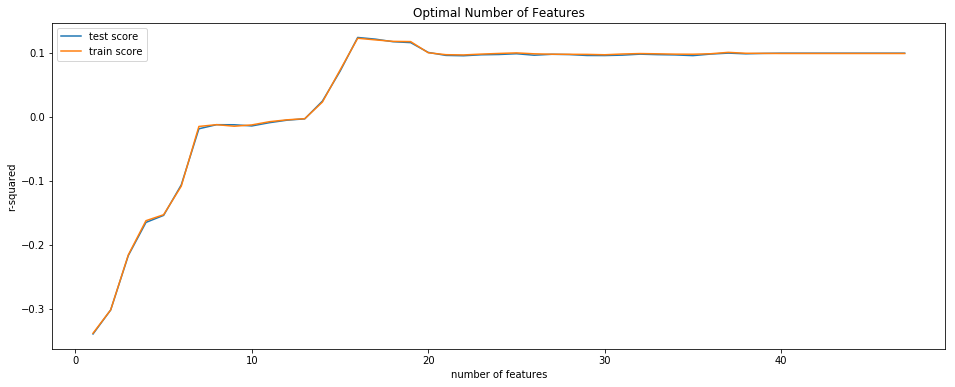

In [82]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [83]:
#### Based on the above graphs, it can be fairly concluded that the optimal feature in this dataset could be 
n_features_optimal = 22

### Feature Selection Using RFE

In [84]:
logreg = LogisticRegression()
from sklearn.feature_selection import RFE
rfe = RFE(logreg, n_features_to_select=n_features_optimal)            
rfe = rfe.fit(X_train,y_train)
print(rfe.support_)           
print(rfe.ranking_)           # Printing the ranking

[ True  True  True  True  True  True  True  True  True False False False
 False False  True False False  True False False  True False False  True
  True  True  True False False  True  True False  True False False  True
  True  True False False]
[ 1  1  1  1  1  1  1  1  1 15 18 10 17 16  1  7  8  1  5 19  1 12  2  1
  1  1  1 14  4  1  1  3  1 11 13  1  1  1  6  9]


In [85]:
clf_lr3 = LogisticRegression()
bm = clf_lr3.fit(X_train, y_train)
generate_accuracy(bm, X_test, y_test)

Accuracy is:  0.7712311116317208
F1 score is:  0.324455205811138


1

In [86]:
selected_rfe_features = pd.DataFrame({'Feature':list(X_train.columns),'Ranking':rfe.ranking_})
selected_rfe_features.sort_values(by='Ranking')

Feature  Ranking
0                arpu_6        1
26         monthly_2g_8        1
25         monthly_2g_7        1
24         monthly_2g_6        1
23          vol_3g_mb_8        1
30         monthly_3g_6        1
20          vol_2g_mb_8        1
17   last_day_rch_amt_8        1
29          sachet_2g_8        1
32         monthly_3g_8        1
35          sachet_3g_8        1
14  date_of_last_rech_8        1
37           aug_vbc_3g        1
1                arpu_7        1
2                arpu_8        1
3      total_rech_num_6        1
4      total_rech_num_7        1
5      total_rech_num_8        1
36                  aon        1
6      total_rech_amt_6        1
7      total_rech_amt_7        1
8      total_rech_amt_8        1
22          vol_3g_mb_7        2
31         monthly_3g_7        3
28          sachet_2g_7        4
18          vol_2g_mb_6        5
38           jul_vbc_3g        6
15   last_day_rch_amt_6        7
16   last_day_rch_amt_7        8
39           jun_vbc_3g        9
11       max_rech_amt_8       10
33          sachet_3g_6       11
21          vol_3g_mb_6       12
34          sachet_3g_7       13
27          sachet_2g_6       14
9        max_rech_amt_6       15
13  date_of_last_rech_7       16
12  date_of_last_rech_6       17
10       max_rech_amt_7       18
19          vol_2g_mb_7       19

In [87]:
#Storing the high rank features from RFE
df_rfeSel = selected_rfe_features.loc[selected_rfe_features['Ranking'].isin([1,2])]

In [88]:
df_rfeSel.head()

Feature  Ranking
0            arpu_6        1
1            arpu_7        1
2            arpu_8        1
3  total_rech_num_6        1
4  total_rech_num_7        1

In [89]:
rfeSelCol = df_rfeSel.Feature

In [90]:
# running the models again with selected variables
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logsk = LogisticRegression(C=1e9)
logsk.fit(X_train[rfeSelCol], y_train)


LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [91]:
#Comparing the model with StatsModels
#logm4 = sm.GLM(y_train,(sm.add_constant(X_train[col])), family = sm.families.Binomial())
logm4 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
modres = logm4.fit()
logm4.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      0   No. Observations:                36810
Model:                            GLM   Df Residuals:                    36769
Model Family:                Binomial   Df Model:                           40
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17961.
Date:                Mon, 07 Oct 2019   Deviance:                       35921.
Time:                        20:37:06   Pearson chi2:                 1.11e+06
No. Iterations:                     6   Covariance Type:             nonrobust
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   4.0200      0.234     17.215      0.000       3.562       4.478
arpu_6                -13.1343      3.969     -3.309      0.001     -20.913      -5.355
arpu_7                 48.5016      6.043      8.026      0.000      36.658      60.345
arpu_8                -53.7846      5.771     -9.320      0.000     -65.096     -42.474
total_rech_num_6       -4.1070      0.855     -4.801      0.000      -5.784      -2.430
total_rech_num_7        5.1227      0.469     10.926      0.000       4.204       6.042
total_rech_num_8       -8.8779      0.719    -12.348      0.000     -10.287      -7.469
total_rech_amt_6       47.7337      4.478     10.660      0.000      38.957      56.510
total_rech_amt_7       -9.5279      6.051     -1.575      0.115     -21.387       2.331
total_rech_amt_8      -21.0766      6.911     -3.050      0.002     -34.622      -7.531
max_rech_amt_6         -3.9687      0.677     -5.862      0.000      -5.296      -2.642
max_rech_amt_7          1.0597      0.576      1.840      0.066      -0.069       2.188
max_rech_amt_8          5.9635      0.836      7.135      0.000       4.325       7.602
date_of_last_rech_6    -0.1981      0.118     -1.674      0.094      -0.430       0.034
date_of_last_rech_7    -0.2594      0.106     -2.441      0.015      -0.468      -0.051
date_of_last_rech_8    -3.4166      0.094    -36.170      0.000      -3.602      -3.231
last_day_rch_amt_6      0.1888      0.562      0.336      0.737      -0.912       1.290
last_day_rch_amt_7     -0.4264      0.522     -0.817      0.414      -1.449       0.596
last_day_rch_amt_8    -21.7751      0.839    -25.963      0.000     -23.419     -20.131
vol_2g_mb_6             3.7266      1.003      3.715      0.000       1.761       5.692
vol_2g_mb_7             0.4597      0.868      0.529      0.596      -1.242       2.161
vol_2g_mb_8            -7.3367      1.511     -4.854      0.000     -10.299      -4.375
vol_3g_mb_6             3.5411      1.483      2.388      0.017       0.635       6.447
vol_3g_mb_7             6.6193      1.508      4.389      0.000       3.663       9.576
vol_3g_mb_8            -7.8687      1.850     -4.254      0.000     -11.494      -4.244
monthly_2g_6           -2.6582      0.278     -9.555      0.000      -3.203      -2.113
monthly_2g_7           -2.3474      0.342     -6.872      0.000      -3.017      -1.678
monthly_2g_8           -4.4269      0.433    -10.230      0.000      -5.275      -3.579
sachet_2g_6             1.9780      0.564      3.509      0.000       0.873       3.083
sachet_2g_7            -3.1771      0.681     -4.664      0.000      -4.512      -1.842
sachet_2g_8            -7.1153      0.682    -10.429      0.000      -8.453      -5.778
monthly_3g_6           -2.8635      0.856     -3.345      0.001      -4.541      -1.186
monthly_3g_7           -3.3433      0.920     -3.632      0.000      -5.147      -

In [92]:
X_test[rfeSelCol].shape

(8537, 23)

In [93]:
np.unique(y_train)

array([0., 1.])

In [94]:
np.unique(y_test)

array([0., 1.])

### Making Predictions

In [160]:
# Predicted probabilities
X_test1 = X_test[rfeSelCol]
y_pred = logsk.predict_proba(X_test1)
# Converting y_pred array to a dataframe 
y_pred_df = pd.DataFrame(y_pred)
# Converting to dataframe
y_pred_1 = y_pred_df.iloc[:,[1]]
y_pred_1.head()

1
0  0.054489
1  0.674797
2  0.564932
3  0.007920
4  0.699053

In [96]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)
y_test_df.head()

churn
12458    0.0
3840     1.0
5960     0.0
23691    0.0
20017    0.0

In [97]:
# Putting ph# to index
y_test_df['mobile_number'] = y_test_df.index
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 1 : 'Churn_Prob'})
# Rearranging the columns
y_pred_final = y_pred_final.reindex_axis(['mobile_number','churn','Churn_Prob'], axis=1)
# Let's see the head of y_pred_final
y_pred_final.head()

mobile_number  churn  Churn_Prob
0          12458    0.0    0.054489
1           3840    1.0    0.674797
2           5960    0.0    0.564932
3          23691    0.0    0.007920
4          20017    0.0    0.699053

In [105]:
# Creating new column 'predicted' with 1 , start with picking the threshold as .5
y_pred_final['predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.5 else 0)
# Let's see the head
y_pred_final.head(3)

mobile_number  churn  Churn_Prob  predicted
0          12458    0.0    0.054489          0
1           3840    1.0    0.674797          1
2           5960    0.0    0.564932          1

### Model Evaluation

In [99]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.churn, y_pred_final.predicted )
confusion

array([[6148, 1769],
       [ 143,  477]], dtype=int64)

In [104]:
#getting the accuracy F1, precision and recall scores.
print("Accuracy : {0}".format(metrics.accuracy_score(y_pred_final.churn, y_pred_final.predicted)))
print("F1 : {0}".format(metrics.f1_score(y_pred_final.churn,y_pred_final.predicted, average="binary")))
print("Precision : {0}".format(precision_score(y_pred_final.churn,y_pred_final.predicted, average="binary")))
print("Recall : {0}".format(recall_score(y_pred_final.churn,y_pred_final.predicted, average="binary")))    

Accuracy : 0.7760337355042755
F1 : 0.33286810886252616
Precision : 0.21237756010685663
Recall : 0.7693548387096775


In [ ]:
#Changing the threshold to see the effect in the confusion matrix and scores
y_pred_final['predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.6 else 0)

In [107]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.churn, y_pred_final.predicted )
confusion

array([[6834, 1083],
       [ 195,  425]], dtype=int64)

In [108]:
#getting the accuracy F1, precision and recall scores.
print("Accuracy : {0}".format(metrics.accuracy_score(y_pred_final.churn, y_pred_final.predicted)))
print("F1 : {0}".format(metrics.f1_score(y_pred_final.churn,y_pred_final.predicted, average="binary")))
print("Precision : {0}".format(precision_score(y_pred_final.churn,y_pred_final.predicted, average="binary")))
print("Recall : {0}".format(recall_score(y_pred_final.churn,y_pred_final.predicted, average="binary")))   

Accuracy : 0.8502986997774393
F1 : 0.3994360902255639
Precision : 0.28183023872679047
Recall : 0.6854838709677419


#### Observations on the confusion matrix and scores
Looking at the Confusion Matrix it can be observed that with threshold keeping at .6 the TN is increased significantly and FP is reduced.
Although the accuracy, F1 and Precision are increased, the Recall is reduced. Since the precision is quite low, it would be ood idea to urther tweak the threshold.

In [109]:
#Trying with .7
y_pred_final['predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.7 else 0)

In [110]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.churn, y_pred_final.predicted )
confusion

array([[7266,  651],
       [ 280,  340]], dtype=int64)

In [111]:
#getting the accuracy F1, precision and recall scores.
print("Accuracy : {0}".format(metrics.accuracy_score(y_pred_final.churn, y_pred_final.predicted)))
print("F1 : {0}".format(metrics.f1_score(y_pred_final.churn,y_pred_final.predicted, average="binary")))
print("Precision : {0}".format(precision_score(y_pred_final.churn,y_pred_final.predicted, average="binary")))
print("Recall : {0}".format(recall_score(y_pred_final.churn,y_pred_final.predicted, average="binary")))   

Accuracy : 0.89094529694272
F1 : 0.42209807572936064
Precision : 0.343087790110999
Recall : 0.5483870967741935


#### Observations on the confusion matrix and scores II
Accuracy, F1, Precision have improved with Recall went down

In [112]:
#Trying with .8
y_pred_final['predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.8 else 0)

In [113]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.churn, y_pred_final.predicted )
confusion

array([[7577,  340],
       [ 383,  237]], dtype=int64)

In [114]:
#getting the accuracy F1, precision and recall scores.
print("Accuracy : {0}".format(metrics.accuracy_score(y_pred_final.churn, y_pred_final.predicted)))
print("F1 : {0}".format(metrics.f1_score(y_pred_final.churn,y_pred_final.predicted, average="binary")))
print("Precision : {0}".format(precision_score(y_pred_final.churn,y_pred_final.predicted, average="binary")))
print("Recall : {0}".format(recall_score(y_pred_final.churn,y_pred_final.predicted, average="binary")))   

Accuracy : 0.9153098278083636
F1 : 0.3959899749373434
Precision : 0.41074523396880414
Recall : 0.38225806451612904


In [137]:
#classification_report(y_pred_final.churn, y_pred_final.predicted)

#### Observations on the confusion matrix and scores III
It's observed that Although Accuracy and Precision have improved, F1 score have started to go down. Also Recall is significantly less. Since the client would want want any customers to go out at the expense of taking appeasing action to keep the customers even if some of them fall in the category of 'False Positive', we should stick to the threshold of .7

#### Final model
As decided previously, the threshold to be kept would .7, the y_pred_final needs to be rebuilt

In [132]:
y_pred_final['predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.4 else 0)

### Building the ROC curve

In [117]:
#a helper function todraw the ROC curve(taken from Upgrad example)
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

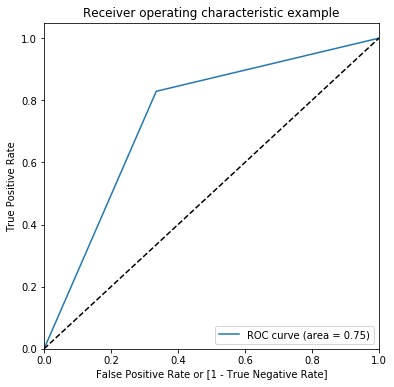

(array([0.        , 0.33510168, 1.        ]),
 array([0.        , 0.82903226, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [133]:
draw_roc(y_pred_final.churn, y_pred_final.predicted)

### Observation on ROC curve
similarly different ROC curves was prepared fr .6,.7,.8 and the ROC curve area appeared as .77,.73, .77

In [135]:
#AUC score
"{:2.2f}".format(metrics.roc_auc_score(y_pred_final.churn, y_pred_final.Churn_Prob))

'0.84'

### Applying PCA 

In [103]:
#At this point the train dataset already notmalized, class balanced and hyper parameter tuned
#Stage set for PCA 

In [138]:
X_train.shape

(36810, 40)

In [139]:
pca = PCA(svd_solver='randomized', random_state=42)

In [140]:
#Doing the PCA on the train data
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

In [141]:
pca.components_

array([[-1.12496909e-03, -1.91037182e-03,  3.97715792e-03, ...,
         1.07141783e-02,  1.64349743e-02,  1.27489829e-02],
       [-1.59115782e-03, -4.85459546e-03, -1.75363101e-02, ...,
        -9.56390441e-04,  6.54534358e-03,  4.93824246e-03],
       [-1.48838232e-04, -1.23348140e-02, -2.51819989e-03, ...,
         1.64739227e-02,  2.06337113e-02,  1.64172692e-02],
       ...,
       [-6.53553376e-01,  5.79202963e-02, -4.14911569e-02, ...,
         2.69399484e-03,  4.96371916e-04,  5.70530595e-03],
       [-1.03563023e-01, -6.19872635e-01,  2.93801153e-01, ...,
         4.48712687e-05, -1.50857513e-04,  1.48401936e-03],
       [ 8.86106003e-03,  3.63103870e-01,  5.54405244e-01, ...,
        -3.61572028e-03,  1.44208933e-03, -7.19871774e-04]])

In [142]:
colnames = list(X_train.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df.head(15)

PC1       PC2              Feature
0  -0.001125 -0.001591               arpu_6
1  -0.001910 -0.004855               arpu_7
2   0.003977 -0.017536               arpu_8
3  -0.041902 -0.021576     total_rech_num_6
4  -0.108916 -0.080461     total_rech_num_7
5  -0.048253 -0.094704     total_rech_num_8
6  -0.000480 -0.000693     total_rech_amt_6
7  -0.001684 -0.005494     total_rech_amt_7
8   0.003164 -0.016940     total_rech_amt_8
9   0.056420  0.028405       max_rech_amt_6
10  0.056177  0.027284       max_rech_amt_7
11  0.045837 -0.001426       max_rech_amt_8
12 -0.184093 -0.104424  date_of_last_rech_6
13 -0.129031 -0.258478  date_of_last_rech_7
14 -0.214574 -0.905407  date_of_last_rech_8

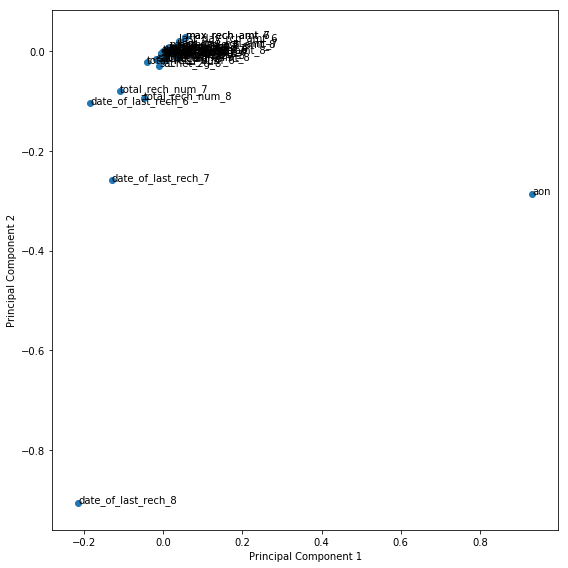

In [143]:
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

In [144]:
#Checking the variance ratio
pca.explained_variance_ratio_

array([2.82043506e-01, 2.39461699e-01, 1.32576042e-01, 9.07126895e-02,
       5.74498407e-02, 3.54426733e-02, 3.12072459e-02, 1.96987961e-02,
       1.80446798e-02, 1.38396629e-02, 9.80478504e-03, 7.79009138e-03,
       7.33955755e-03, 5.85480243e-03, 5.70340384e-03, 4.69734195e-03,
       4.52701590e-03, 4.37629982e-03, 3.63551630e-03, 3.38828721e-03,
       2.82368051e-03, 2.65434707e-03, 2.44558727e-03, 1.92506069e-03,
       1.75594510e-03, 1.62199849e-03, 1.39547314e-03, 1.35956740e-03,
       1.22833227e-03, 1.13820596e-03, 1.07365015e-03, 8.52408402e-04,
       7.67417559e-04, 3.94739472e-04, 3.44874616e-04, 2.88012069e-04,
       2.57570790e-04, 3.79942727e-05, 2.52442603e-05, 1.59535991e-05])

### Scree plot

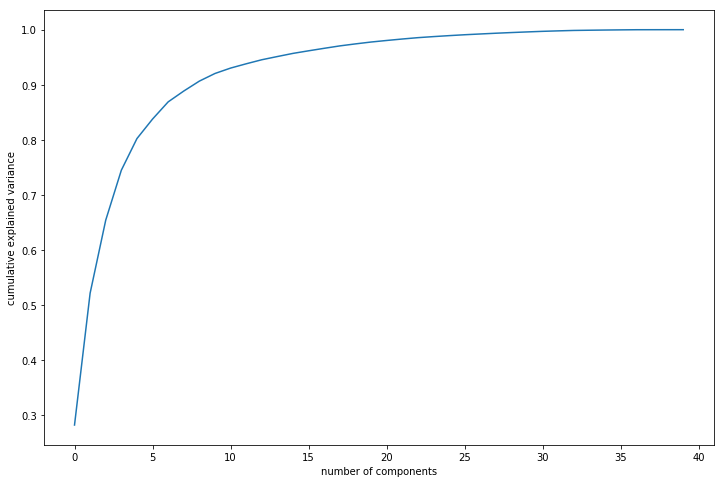

In [145]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [146]:
#Screeplot suggests about 22 components can explan more than 92% of the variance in the dataset
pca_coms_toSelect = 22

In [147]:
#Using incremental PCA for efficiency 
from sklearn.decomposition import IncrementalPCA
#selecting 14 components as suggested by Scree plot
pca_final = IncrementalPCA(pca_coms_toSelect)

In [163]:
X_train_pca = pca_final.fit_transform(X_train)
X_train_pca.shape

(36810, 22)

In [164]:
type(X_train_pca)

numpy.ndarray

In [165]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(X_train_pca.transpose())

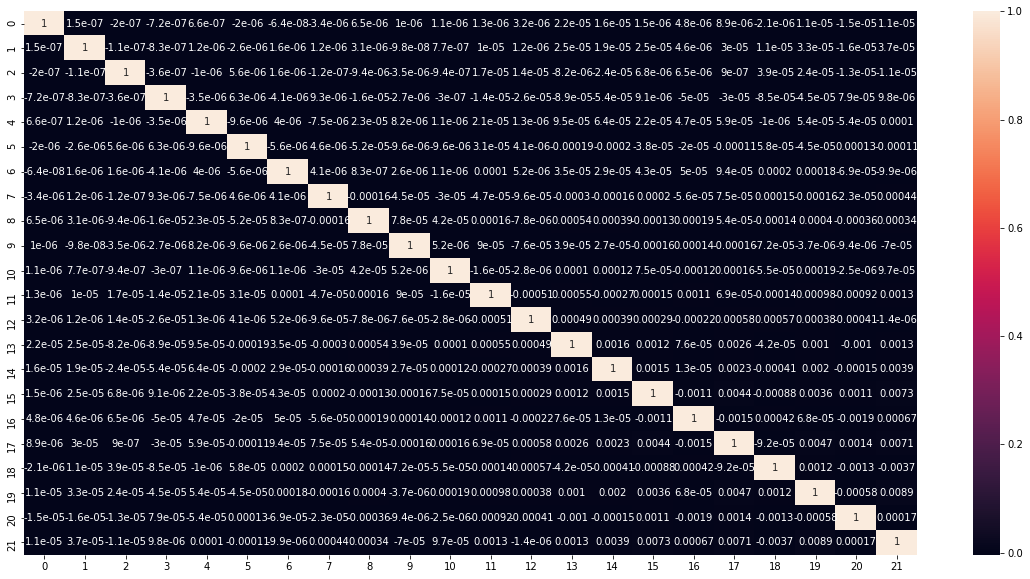

In [166]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True)

In [151]:
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
# we see that correlations are indeed very close to 0

max corr: 0.008880504999520276 , min corr:  -0.003676727217785475


#### Looking at the max colinearity and min collinearity it can be concluded that, after doing PCA, the multi-collinearity is successfully removed

In [169]:
#Applying selected components to the test data - 16 components
X_test_pca = pca_final.transform(X_test)
X_test_pca.shape

(8537, 22)

In [170]:
type(X_test_pca)

numpy.ndarray

### Applying Logistic Regression & Making Prediction
Applying the logisic regression on the model we got from PCA

In [171]:
#Training the model on the train data
learner_pca = LogisticRegression()
model_pca = learner_pca.fit(X_train_pca,y_train)

In [172]:
#Making prediction on the test data
pred_probs_test = model_pca.predict_proba(X_test_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.82'

In [173]:
generate_accuracy(model_pca, X_test_pca, y_test)

Accuracy is:  0.7617430010542345
F1 score is:  0.3142279163857047


1

###  Model Evaluation
Observing the Matrix and scores

In [176]:
y_pred_df = pd.DataFrame(pred_probs_test)
y_pred_1 = y_pred_df.iloc[:,[0]]
y_pred_1.head()

0
0  0.054964
1  0.720099
2  0.645774
3  0.012660
4  0.694078

In [178]:
y_test_df.head()

churn  mobile_number
0    0.0              0
1    1.0              1
2    0.0              2
3    0.0              3
4    0.0              4

In [179]:
y_pred_1.head()

0
0  0.054964
1  0.720099
2  0.645774
3  0.012660
4  0.694078

In [219]:
# Putting ph# to index
#y_test_df['mobile_number'] = y_test_df.index
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)
y_pred_final.head()


churn  mobile_number         0
0    0.0              0  0.054964
1    1.0              1  0.720099
2    0.0              2  0.645774
3    0.0              3  0.012660
4    0.0              4  0.694078

In [220]:
#verifying the columns
y_pred_final.columns

Index(['churn', 'mobile_number', 0], dtype='object')

In [222]:
# Renaming the column 
y_pred_final.rename(columns={0:'Churn_Prob', "mobile_number":"No#"}, inplace=True)

In [223]:
y_pred_final.head()

churn  No#  Churn_Prob
0    0.0    0    0.054964
1    1.0    1    0.720099
2    0.0    2    0.645774
3    0.0    3    0.012660
4    0.0    4    0.694078

In [215]:
# Rearranging the columns
#y_pred_final = y_pred_final.reindex_axis(['mobile_number','churn','Churn_Prob'], axis=1)
# Let's see the head of y_pred_final
#y_pred_final.head()

In [224]:
# Creating new column 'predicted' with 1 if Churn_Prob>0.5 else 0
y_pred_final['predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.5 else 0)
y_pred_final.head(3)

churn  No#  Churn_Prob  predicted
0    0.0    0    0.054964          0
1    1.0    1    0.720099          1
2    0.0    2    0.645774          1

In [225]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.churn, y_pred_final.predicted )
confusion

array([[6037, 1880],
       [ 154,  466]], dtype=int64)

In [226]:
#getting the accuracy F1, precision and recall scores.
print("Accuracy : {0}".format(metrics.accuracy_score(y_pred_final.churn, y_pred_final.predicted)))
print("F1 : {0}".format(metrics.f1_score(y_pred_final.churn,y_pred_final.predicted, average="binary")))
print("Precision : {0}".format(precision_score(y_pred_final.churn,y_pred_final.predicted, average="binary")))
print("Recall : {0}".format(recall_score(y_pred_final.churn,y_pred_final.predicted, average="binary")))   

Accuracy : 0.7617430010542345
F1 : 0.3142279163857047
Precision : 0.19863597612958228
Recall : 0.7516129032258064


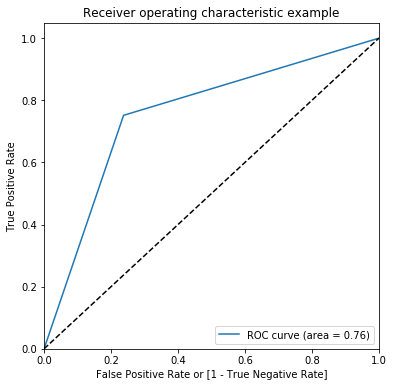

(array([0.        , 0.23746369, 1.        ]),
 array([0.       , 0.7516129, 1.       ]),
 array([2, 1, 0], dtype=int64))

In [227]:
draw_roc(y_pred_final.churn, y_pred_final.predicted)

#### Observation
No remarkable differences found between the scores before PCA and after at the  same threshold of .5

In [244]:
# Creating new column 'predicted' with 1 if Churn_Prob>.6else 0
y_pred_final['predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.6 else 0)
y_pred_final.head(3)

churn  No#  Churn_Prob  predicted
0    0.0    0    0.054964          0
1    1.0    1    0.720099          1
2    0.0    2    0.645774          1

In [245]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.churn, y_pred_final.predicted )
confusion

array([[6811, 1106],
       [ 223,  397]], dtype=int64)

In [246]:
#getting the accuracy F1, precision and recall scores.
print("Accuracy : {0}".format(metrics.accuracy_score(y_pred_final.churn, y_pred_final.predicted)))
print("F1 : {0}".format(metrics.f1_score(y_pred_final.churn,y_pred_final.predicted, average="binary")))
print("Precision : {0}".format(precision_score(y_pred_final.churn,y_pred_final.predicted, average="binary")))
print("Recall : {0}".format(recall_score(y_pred_final.churn,y_pred_final.predicted, average="binary")))   

Accuracy : 0.8443247042286518
F1 : 0.37399905793688176
Precision : 0.26413838988689287
Recall : 0.6403225806451613


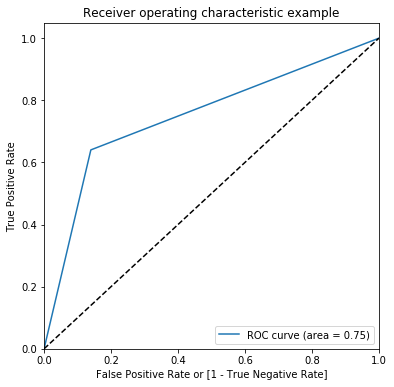

(array([0.        , 0.13969938, 1.        ]),
 array([0.        , 0.64032258, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [233]:
draw_roc(y_pred_final.churn, y_pred_final.predicted)

#### Observation
At threshold .6 the results are almost comparable beteen the model with PCA & without PCA. 
With PCA .6 seems to have fared better than the .5 with regards to Accuracy, F1 and Precision. However Recall is significantly low.


In [248]:
# Creating new column 'predicted' with 1 if Churn_Prob>.7 else 0
y_pred_final['predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.7 else 0)
y_pred_final.head(3)

churn  No#  Churn_Prob  predicted
0    0.0    0    0.054964          0
1    1.0    1    0.720099          1
2    0.0    2    0.645774          0

In [249]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.churn, y_pred_final.predicted )
confusion

array([[7312,  605],
       [ 321,  299]], dtype=int64)

In [250]:
print("Accuracy : {0}".format(metrics.accuracy_score(y_pred_final.churn, y_pred_final.predicted)))
print("F1 : {0}".format(metrics.f1_score(y_pred_final.churn,y_pred_final.predicted, average="binary")))
print("Precision : {0}".format(precision_score(y_pred_final.churn,y_pred_final.predicted, average="binary")))
print("Recall : {0}".format(recall_score(y_pred_final.churn,y_pred_final.predicted, average="binary")))    

Accuracy : 0.8915309827808363
F1 : 0.39238845144356954
Precision : 0.3307522123893805
Recall : 0.482258064516129


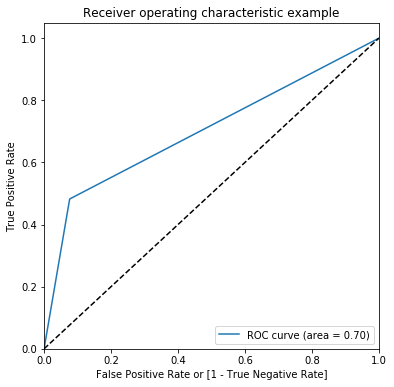

(array([0.        , 0.07641784, 1.        ]),
 array([0.        , 0.48225806, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [251]:
draw_roc(y_pred_final.churn, y_pred_final.predicted)

#### Observation
At .7 there's slight divergence between the model with PCA and the one without in regards to Precision and Recall.
Accuracy and Precision is almost same, however F1 and Recall is slightly better in the model before PCA.

#### Before PCA scores 
Accuracy : 0.89094529694272
F1 : 0.42209807572936064
Precision : 0.343087790110999
Recall : 0.5483870967741935
#### After PCA score
Accuracy : 0.8915309827808363
F1 : 0.39238845144356954
Precision : 0.3307522123893805
Recall : 0.482258064516129

In [255]:
# Creating new column 'predicted' with 1 if Churn_Prob>.8 else 0
y_pred_final['predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.8 else 0)
y_pred_final.head(3)

churn  No#  Churn_Prob  predicted
0    0.0    0    0.054964          0
1    1.0    1    0.720099          0
2    0.0    2    0.645774          0

In [256]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.churn, y_pred_final.predicted )
confusion

array([[7624,  293],
       [ 443,  177]], dtype=int64)

In [257]:
#getting the accuracy F1, precision and recall scores.
print("Accuracy : {0}".format(metrics.accuracy_score(y_pred_final.churn, y_pred_final.predicted)))
print("F1 : {0}".format(metrics.f1_score(y_pred_final.churn,y_pred_final.predicted, average="binary")))
print("Precision : {0}".format(precision_score(y_pred_final.churn,y_pred_final.predicted, average="binary")))
print("Recall : {0}".format(recall_score(y_pred_final.churn,y_pred_final.predicted, average="binary")))   

Accuracy : 0.9137870446292609
F1 : 0.3247706422018348
Precision : 0.37659574468085105
Recall : 0.2854838709677419


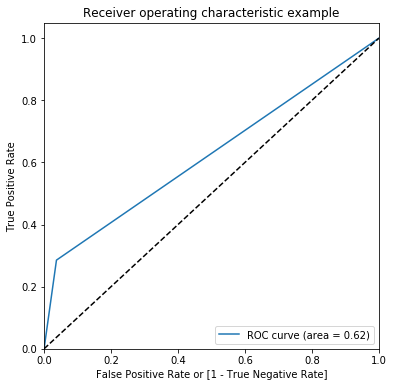

(array([0.        , 0.03700897, 1.        ]),
 array([0.        , 0.28548387, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [258]:
draw_roc(y_pred_final.churn, y_pred_final.predicted)

In [ ]:
Observation
At .8 The model didn't fare very well. Based on the scores, .7 can be the one that would be the optimal one.

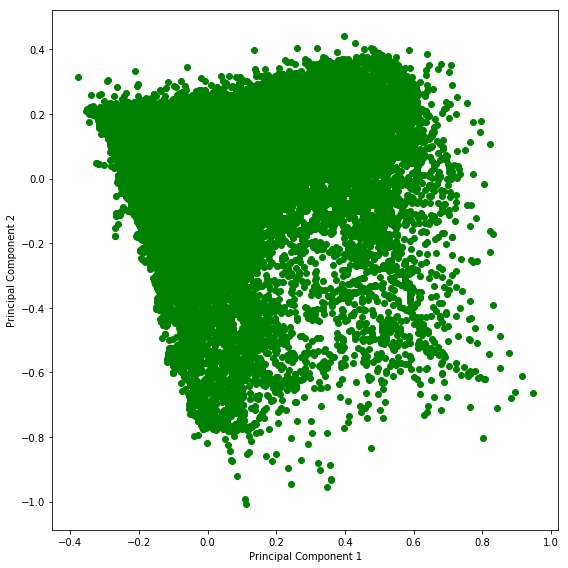

In [156]:
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(df_train_pca[:,0], df_train_pca[:,1], c = y_train.iloc[0,:].map({0:'green',1:'red'}))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

In [123]:
#Test cell - Not for evaluation - to be removed
#Building the model with 11 features
pca_last = PCA(n_components=11)
df_train_pca3 = pca_last.fit_transform(X_train)
df_test_pca3 = pca_last.transform(X_test)
df_test_pca3.shape

(8537, 11)

In [124]:
#Test cell - Not for evaluation - to be removed
#training the regression model
learner_pca3 = LogisticRegression()
model_pca3 = learner_pca3.fit(df_train_pca3,y_train)
#Making prediction on the test data
pred_probs_test3 = model_pca3.predict_proba(df_test_pca3)[:,1]
"{:2.2f}".format(metrics.roc_auc_score(y_test, pred_probs_test3))

'0.78'

In [125]:
roc_auc_score(y, prob_y)

0.9997453104583494

## Conclusion :
We have built the model firstly without using PCA, i.e by manual feature elimination and RFE and then proceeded with application of PCA. It's been observed that with the given dataset and technique, we didn't find a remarkable difference in terms of scores. 
However PCA turned out to be very convenient and fast. Since it's comparable with the result, PCA could have been used straightway to derive the final goal.

From business perspective, it would be wise to keep the threshold and .7 to determine the customers with probability of churn and need to be reached out with appropriate measures.

## Building the Model for find out important predictor attributes . This step includes:
##### NOTE: For building this model, Random Forest has been chosen as it can handle multicollinearity and also works great on larger data sets
1. Building stanadard RF Models.
2. Tuning the below hyper-parameters individually
3. Tuning the hyper-parameters together to arrive at the right set of params
4. Building the final model
5. Extracting the important features
6. Plotting the important features, analyzing them and recommending strategies for each

In [126]:
# Splitting into testing and training sets

X_rf = high_value_customers_2.drop('churn',axis=1)
y_rf = high_value_customers_2['churn']

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.30, random_state=100)

In [127]:
# Checking for percentage of churn data
y_train_rf.sum()/y_train_rf.count() * 100

7.596144191183854

The percentage of chrun data is 7.6% which means that there is class imbalance

To overcome this, Random Forest Algorithm is chosen which is an ensemble bagging algoritihm

Also two approaches will be used:
1. Standard Random Forest
2. Random Forest by Balancing the Class Weights (class_weight = balanced)

In [134]:
# Using standard Random Forest 

rfc = RandomForestClassifier()
rfc.fit(X_train_rf,y_train_rf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [135]:
# Calculating accuracy 

predictions = rfc.predict(X_test_rf)

print(confusion_matrix(y_test_rf,predictions))

print(accuracy_score(y_test_rf,predictions))

[[7822   95]
 [ 476  144]]
0.9331146772871032


In [132]:
# Using Random Forest with balanced class weights 

rfc_balanced = RandomForestClassifier(class_weight='balanced')
rfc_balanced.fit(X_train_rf,y_train_rf)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [133]:
# Calculating accuracy 

predictions_balanced = rfc_balanced.predict(X_test_rf)

print(confusion_matrix(y_test_rf,predictions_balanced))

print(accuracy_score(y_test_rf,predictions_balanced))

[[7841   76]
 [ 483  137]]
0.9345203232985826


From the above results, it can be seen that:
1. There is slight boost in the accuracy of the balanced RF 
2. Also the number of misclassifications for churn=1 as well as churn=0 is lesser 


Therefore the balanced RF approached will be used 

###### Hyperparameter Tuning for RF Classification 


The below hyperparameters will be tuned :
1. n_estimators
2. max_features
3. min_samples_split
4. min_samples_leaf
5. max_depth


In [141]:
# Defining a function that performs a 5 fold Grid-Search CV. This will be used for hyper-parameter tuning.

def gridSearch(params):
    rf = RandomForestClassifier(class_weight='balanced')
    rf = GridSearchCV(rf, 
                      params, 
                      cv=5, 
                      scoring="accuracy")
    rf.fit(X_train_rf, y_train_rf)
    return rf

In [137]:
# Defining a function to plot the accuracy for the parameters that are being tuned.

def plotAccuracies(score, plot_param):
    plt.figure()
    plt.plot(score[plot_param], 
             score["mean_train_score"], 
             label="training accuracy")
    plt.plot(score[plot_param], 
             score["mean_test_score"], 
             label="test accuracy")
    plt.xlabel(plot_param)
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [138]:
# Grid Search CV to find the optimal value for n_estimators

n_estimators = {'n_estimators': range(100, 1500, 400)}

rf = gridSearch(n_estimators)

scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       8.550816      0.885462         0.130875        0.008796   
1      44.635678      0.524577         0.703339        0.031238   
2      80.108871      0.878123         1.289447        0.075778   
3     112.604090      0.889679         1.808171        0.090594   

  param_n_estimators                  params  split0_test_score  \
0                100   {'n_estimators': 100}           0.912388   
1                500   {'n_estimators': 500}           0.917414   
2                900   {'n_estimators': 900}           0.917414   
3               1300  {'n_estimators': 1300}           0.917414   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.964548           0.970117           0.965906           0.965227   
1           0.964140           0.970253           0.966993           0.965499   
2           0.964819           0.970117           0.967264           0.966585   
3           0.963189           0.969438           0.967400           0.966178   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0         0.955637        0.021712                4                 1.0   
1         0.956860        0.019828                2                 1.0   
2         0.957240        0.019986                1                 1.0   
3         0.956724        0.019759                3                 1.0   

   split1_train_score  split2_train_score  split3_train_score  \
0                 1.0                 1.0                 1.0   
1                 1.0                 1.0                 1.0   
2                 1.0                 1.0                 1.0   
3                 1.0                 1.0                 1.0   

   split4_train_score  mean_train_score  std_train_score  
0                 1.0               1.0              0.0  
1                 1.0               1.0              0.0  
2                 1.0               1.0              0.0  
3                 1.0               1.0              0.0

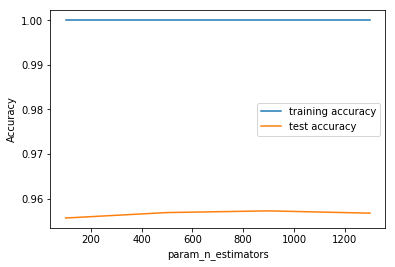

In [139]:
# Plotting the accuracy of the different n_estimators

plotAccuracies(scores, 'param_n_estimators')

It can be seen that the test accuracy does not have drastic changes with change in n_estimators

In [142]:
# Grid Search CV to find the optimal value for max_features

max_features = {'max_features': range(5, 60, 5)}

rf = gridSearch(max_features)

scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.499380      0.087507         0.012172        0.001225   
1       0.981124      0.142479         0.015719        0.004324   
2       1.431672      0.107917         0.012958        0.002387   
3       1.765291      0.235388         0.013408        0.003090   
4       2.652848      0.190034         0.013451        0.003153   

  param_max_features                params  split0_test_score  \
0                  5   {'max_features': 5}           0.926456   
1                 10  {'max_features': 10}           0.934237   
2                 15  {'max_features': 15}           0.932731   
3                 20  {'max_features': 20}           0.932731   
4                 25  {'max_features': 25}           0.930723   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.930723           0.926707           0.932212           0.927944   
1           0.929970           0.930723           0.930957           0.927693   
2           0.926958           0.926707           0.934974           0.928948   
3           0.927711           0.929217           0.931459           0.926939   
4           0.930974           0.931476           0.931208           0.926186   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0         0.928808        0.002278               11            0.991151   
1         0.930716        0.002105                2            0.991465   
2         0.930063        0.003267                5            0.990398   
3         0.929611        0.002193                8            0.990963   
4         0.930113        0.001979                4            0.991214   

   split1_train_score  split2_train_score  split3_train_score  \
0            0.990586            0.992469            0.991214   
1            0.990900            0.990712            0.991089   
2            0.990774            0.990837            0.991528   
3            0.991528            0.991465            0.990712   
4            0.990021            0.990774            0.991654   

   split4_train_score  mean_train_score  std_train_score  
0            0.991340          0.991352         0.000615  
1            0.992156          0.991264         0.000511  
2            0.991026          0.990913         0.000369  
3            0.991779          0.991289         0.000392  
4            0.992093          0.991151         0.000716

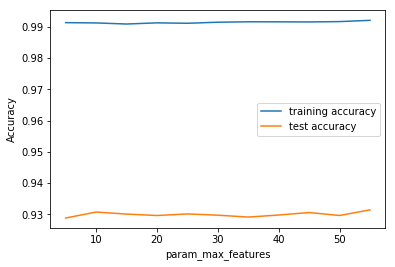

In [143]:
# Plotting the accuracy of the different max_features

plotAccuracies(scores, 'param_max_features')

Accuracy does not vary too much as max features increase also there are occasional but the overall accuracy remains
unaffected 

In [144]:
# Grid Search CV to find the optimal value for min_samples_leaf

min_samples_leaf = {'min_samples_leaf': range(10, 500, 50)}

rf = gridSearch(min_samples_leaf)

scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.924398      0.145258         0.012502        0.002436   
1       0.844701      0.050198         0.011663        0.002053   
2       0.750618      0.072044         0.010713        0.001477   
3       0.517304      0.019135         0.007738        0.000878   
4       0.462058      0.017372         0.007142        0.000276   

  param_min_samples_leaf                     params  split0_test_score  \
0                     10   {'min_samples_leaf': 10}           0.919177   
1                     60   {'min_samples_leaf': 60}           0.875753   
2                    110  {'min_samples_leaf': 110}           0.862450   
3                    160  {'min_samples_leaf': 160}           0.842369   
4                    210  {'min_samples_leaf': 210}           0.842369   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.917169           0.918926           0.926437           0.913884   
1           0.878765           0.885291           0.878484           0.872458   
2           0.866215           0.865713           0.853628           0.856139   
3           0.856426           0.861195           0.849109           0.852373   
4           0.846386           0.852661           0.847602           0.844841   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0         0.919118        0.004118                1            0.952492   
1         0.878150        0.004234                2            0.892243   
2         0.860829        0.005086                3            0.873102   
3         0.852294        0.006403                4            0.857537   
4         0.846772        0.003424                5            0.852893   

   split1_train_score  split2_train_score  split3_train_score  \
0            0.954123            0.952240            0.950235   
1            0.884586            0.893686            0.888045   
2            0.869336            0.869587            0.858425   
3            0.855906            0.855529            0.853342   
4            0.853709            0.851764            0.854597   

   split4_train_score  mean_train_score  std_train_score  
0            0.954314          0.952681         0.001480  
1            0.889677          0.889648         0.003201  
2            0.867399          0.867570         0.004928  
3            0.862943          0.857051         0.003235  
4            0.855852          0.853763         0.001401

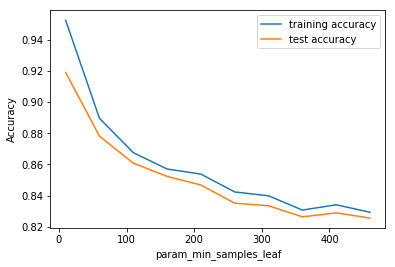

In [145]:
# Plotting the accuracy of the different max_features

plotAccuracies(scores, 'param_min_samples_leaf')

Lower the samples per leaf higher the accuracy for both the testing and training data

In [146]:
# Grid Search CV to find the optimal value for min_samples_split

min_samples_split = {'min_samples_split': range(10, 500, 50)}

rf = gridSearch(min_samples_split)

scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.865690      0.081786         0.011484        0.003755   
1       0.751551      0.036591         0.008703        0.000355   
2       0.696929      0.020794         0.008128        0.000109   
3       0.691128      0.008253         0.008061        0.000430   
4       0.665928      0.031403         0.007717        0.000092   

  param_min_samples_split                      params  split0_test_score  \
0                      10   {'min_samples_split': 10}           0.929217   
1                      60   {'min_samples_split': 60}           0.910141   
2                     110  {'min_samples_split': 110}           0.899096   
3                     160  {'min_samples_split': 160}           0.878012   
4                     210  {'min_samples_split': 210}           0.875000   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.929970           0.928464           0.936731           0.928195   
1           0.912400           0.911647           0.921918           0.909616   
2           0.898594           0.900853           0.904846           0.887271   
3           0.890813           0.884287           0.883254           0.883003   
4           0.884789           0.882028           0.877730           0.872207   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0         0.930515        0.003169                1            0.987197   
1         0.913144        0.004500                2            0.947534   
2         0.898132        0.005858                3            0.922430   
3         0.883874        0.004095                4            0.900339   
4         0.878351        0.004568                5            0.895569   

   split1_train_score  split2_train_score  split3_train_score  \
0            0.987825            0.986946            0.988077   
1            0.950420            0.948412            0.950424   
2            0.929271            0.927137            0.917791   
3            0.909941            0.901657            0.901349   
4            0.894942            0.893435            0.889426   

   split4_train_score  mean_train_score  std_train_score  
0            0.989583          0.987925         0.000924  
1            0.950926          0.949543         0.001325  
2            0.921933          0.923712         0.004062  
3            0.905491          0.903755         0.003554  
4            0.893442          0.893363         0.002139

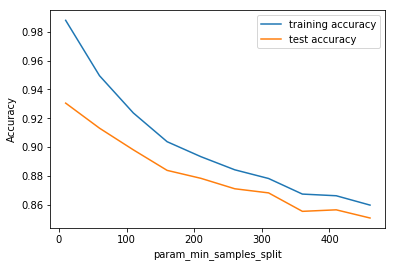

In [147]:
# Plotting the accuracy of the different max_features

plotAccuracies(scores, 'param_min_samples_split')

Lower the samples per split higher the accuracy for both the testing and training data

In [148]:
# Grid Search CV to find the optimal value for min_samples_split

max_depth = {'max_depth': range(2, 45, 5)}

rf = gridSearch(max_depth)

scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.190644      0.038659         0.006759        0.001754   
1       0.542648      0.048634         0.008709        0.002366   
2       0.700250      0.065381         0.008174        0.000374   
3       0.739991      0.025610         0.008925        0.000246   
4       0.759448      0.010684         0.009720        0.001301   

  param_max_depth             params  split0_test_score  split1_test_score  \
0               2   {'max_depth': 2}           0.843373           0.813002   
1               7   {'max_depth': 7}           0.888303           0.899347   
2              12  {'max_depth': 12}           0.928715           0.924950   
3              17  {'max_depth': 17}           0.934990           0.926205   
4              22  {'max_depth': 22}           0.931476           0.930974   

   split2_test_score  split3_test_score  split4_test_score  mean_test_score  \
0           0.848143           0.841326           0.841828         0.837534   
1           0.900351           0.902837           0.895556         0.897279   
2           0.928464           0.930705           0.923173         0.927202   
3           0.932731           0.935225           0.928446         0.931519   
4           0.931225           0.933969           0.934974         0.932523   

   std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0        0.012501                9            0.849692            0.814234   
1        0.005063                8            0.913518            0.914773   
2        0.002737                7            0.971696            0.966173   
3        0.003604                2            0.978474            0.978411   
4        0.001630                1            0.982239            0.982992   

   split2_train_score  split3_train_score  split4_train_score  \
0            0.839337            0.844995            0.851773   
1            0.923058            0.915030            0.920176   
2            0.966487            0.967179            0.969752   
3            0.978976            0.979354            0.978475   
4            0.983306            0.981487            0.983558   

   mean_train_score  std_train_score  
0          0.840006         0.013578  
1          0.917311         0.003668  
2          0.968257         0.002131  
3          0.978738         0.000369  
4          0.982717         0.000758

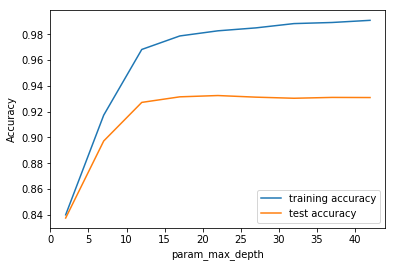

In [149]:
# Plotting the accuracy of the different max_features

plotAccuracies(scores, 'param_max_depth')

Accuracy is less at lower values of max depth and it increases substantially as max depth increases till it finally stays constant and has a slight drop at higher values.

The above hyperparamters will be tuned together using the best porssible values for ranges to arrive at the ideal parameters for buliding the final model

In [150]:
# Perfroming Grid-Search CV for finding out the ideal parameters based on the data above.

param_grid = {
    'n_estimators': [100, 125, 150], 
    'max_features': [5, 10, 15],
    'min_samples_leaf': range(10, 160, 50),
    'min_samples_split': range(10, 160, 50),
    'max_depth': [12, 14, 16]
}


rf = RandomForestClassifier(class_weight='balanced')

rf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

rf.fit(X_train_rf, y_train_rf)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 729 out of 729 | elapsed: 33.5min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 125, 150], 'max_features': [5, 10, 15], 'min_samples_leaf': range(10, 160, 50), 'min_samples_split': range(10, 160, 50), 'max_depth': [12, 14, 16]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [151]:
# Best Params for the Grid-Search 

rf.best_params_

{'max_depth': 14,
 'max_features': 15,
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 100}

In [152]:
# Best score for the best params

rf.best_score_

0.9271513204136962

In [153]:
# Building the final model based on the above results.

rf_final = RandomForestClassifier(class_weight='balanced',
                                  max_depth=14,
                                  min_samples_leaf=10, 
                                  min_samples_split=10,
                                  max_features=15,
                                  n_estimators=100)

rf_final.fit(X_train_rf,y_train_rf)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=14, max_features=15,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [154]:
# Calculating accuracy 

predictions_final = rf_final.predict(X_test_rf)

print(confusion_matrix(y_test_rf,predictions_final))

print(accuracy_score(y_test_rf,predictions_final))

[[7523  394]
 [ 234  386]]
0.9264378587325759


In [182]:
# Making a list of the 10 most important features 

df_features = pd.DataFrame()
df_features['col'] = list(X_rf.columns)
df_features['importance'] = list(rf_final.feature_importances_)
sorted_df_features = df_features.sort_values(['importance'], ascending=False).head(10)
sorted_df_features

col  importance
66          loc_ic_mou_8    0.066183
102  date_of_last_rech_8    0.064658
81        total_ic_mou_8    0.060923
96      total_rech_amt_8    0.049091
105   last_day_rch_amt_8    0.044743
3                 arpu_8    0.041416
60      loc_ic_t2m_mou_8    0.040081
30          loc_og_mou_8    0.039470
21      loc_og_t2m_mou_8    0.038646
12         roam_ic_mou_8    0.034802

###### The important features have now been identified and the analysis will be done as follows:
1. The average of the feature will be calculated for churn and non chruning customers
2. Based on the average, the trend for churn and non-churners will be analyzed
3. Based on this trend, possible deductions will be made and recommendations will be provided

In [183]:
# Defining a function to plot the average of the important factors for churn and not-chrun customers

def plotAvg(col):
    grouped_mean = high_value_customers_2[[col, 'churn']].groupby(['churn'])
    grouped_mean.mean().plot.bar()    

In [184]:
# Converting Important features into a list.

important_features_list = list(sorted_df_features['col'])

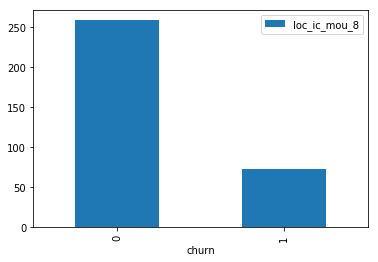

In [185]:
# Analysing 1st Important Feature

plotAvg(important_features_list[0])

The first important factor affecting churn is the local incoming calls for the 8th month. It can be seen that the average local incoming calls for the 8th month is considerably less for the churners as compared to the non-churners. This could mean that the customer has already switched to another provider and the calls the customer may be receiving are from the contacts of the customer who may be unaware of this. 
A possible strategy would be check for the local incoming calls for the 8th month for every customer and if it is below 75, then this customer would be likely to churn and can be targeted with the necessary steps and marketing-strategies, like informing the customer of new offers and plans, to keep the customer from chruning.

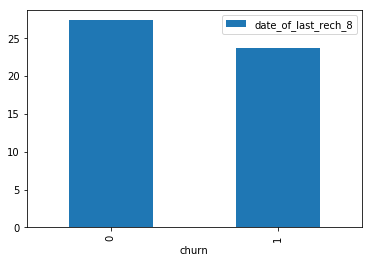

In [186]:
# Analysing 2nd Important Feature

plotAvg(important_features_list[1])

The second important factor affecting churn is the date of last recharge done in the 8th month. It can be seen that the average date of last recharge done the in 8th month is before the 25th for the churners. It could mean that the customer has another provider and the recharge being done before the 25th could also mean that the usage is comparatively less.


A possible strategy would be check for the date of last recharge done in the 8th month for every customer and if it is before the 25th, then this customer would be likely to churn and can be targeted with recharge pack offers/discounts during the final week of the month to make the customer to recharge after the 25th and also reconsider swithcing to other networks and prevent the customer from churning. 

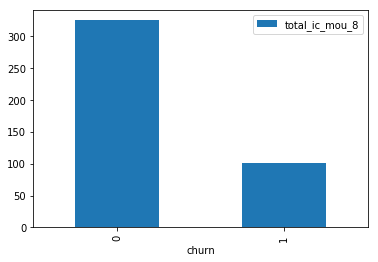

In [187]:
# Analysing 3rd Important Feature

plotAvg(important_features_list[2])

The third factor is similar to the first one but it contains the data of all the incoming calls for the 8th month. A similar strategy can be employed where the condition to be checked would be the total incoming calls for the 8th month for every customer and if it is below 100, then this customer would be likely to churn and can be targeted with the necessary steps and marketing-strategies, like informing the customer of new offers and plans, to keep the customer from chruning.

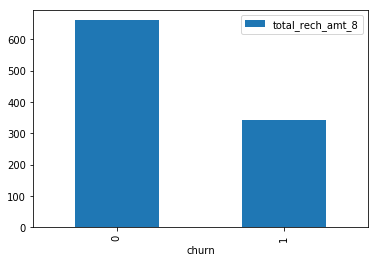

In [188]:
# Analysing 4th Important Feature

plotAvg(important_features_list[3])

The fourth important factor affecting churn is the total recharge amount for the 8th month. It can be seen that the average of total recharge amount for the 8th month is less than half for the churners as compared to the non-churners. This could mean that the customer has another provider and is still using the current provider to some extent and hence the drop in the total recharge amount.


A possible strategy would be check for the total recharge amount for the 8th month for every customer and if it is below 350, then this customer would be likely to churn and can be targeted with offers/discounts and cashbacks related to recharge packs/schemes, including long term packs like 6 months or 12 months (yearly packs), to make the customer to reconsider swithcing to other networks and prevent the customer from churning. 

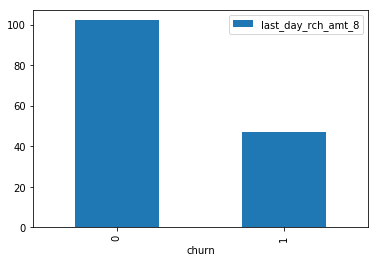

In [189]:
# Analysing 5th Important Feature

plotAvg(important_features_list[4])

The fifth important factor affecting churn is the final recharge amount for the 8th month. It can be seen that the average of last recharge amount for the last day on which the recharge was done in the 8th month is less than half for the churners as compared to the non-churners. This is a simlar case as the 4th factor and it could mean that the customer already has another provider and is still using the current provider to some extent and hence the drop.


A possible strategy would be check for the last day recharge amount for the 8th month for every customer and if it is below 50, then this customer would be likely to churn and can be targeted with month end offers/discounts and cashbacks related to recharge packs/schemes, to make the customer to reconsider swithcing to other networks and prevent the customer from churning. 

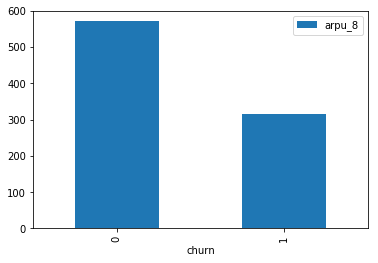

In [190]:
# Analysing 6th Important Feature

plotAvg(important_features_list[5])

The sixth important factor affecting churn is the average revenue per user for the 8th month. It can be seen that the average revenue per user in the 8th month for the churners is marginally above half of that of the non-churners. This indicates that the customer is now using the provider lesser than before indicating the possibility of a switch to another telecom provider.


A possible strategy would be check for the average revenue for the 8th month for every customer and if it is below 300, then this customer would be likely to churn and can be targeted with offers/discounts and cashbacks related to recharge packs/schemes, to make the customer to use the provider's services more so as to generate more revenue and possibly prevent the customer from churning.

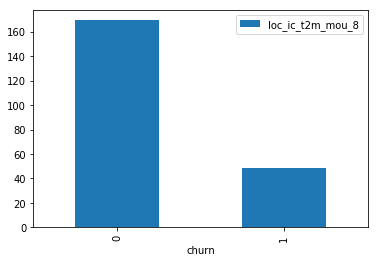

In [191]:
# Analysing 7th Important Feature

plotAvg(important_features_list[6])

The seventh important factor affecting churn is the local incoming calls from other mobile operators for the 8th month. It can be seen that the average local incoming calls from other mobile operators for the 8th month is considerably less for the churners as compared to the non-churners. Similar to the first factor, this could mean that the customer has already switched to another provider and the calls the customer may be receiving are from the contacts of the customer who may be unaware of this and who are using other mobile operators. 


A possible strategy would be check for the local incoming calls for the 8th month for every customer and if it is below 75, then this customer would be likely to churn and can be targeted with the necessary steps and marketing-strategies, like informing the customer of new offers and plans, to keep the customer from chruning.

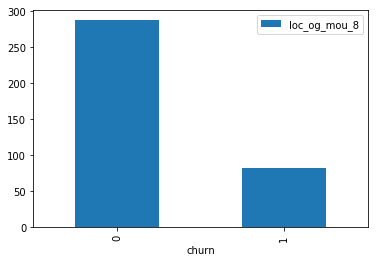

In [192]:
# Analysing 8th Important Feature

plotAvg(important_features_list[7])

The eighth important factor affecting churn is the local outgoing calls for the 8th month. It can be seen that the average of the local outgoing calls for the 8th month considerably less for the churners as compared to the non-churners. This could mean that the customer could have switched to another provider but is still using the current provider to make very few local outgoing calls. 

A possible strategy would be check for the local outgoing calls for the 8th month for every customer and if it is below 100, then this customer would be more likely to churn and can be targeted with talktime packages that offer  discounts and low local outgoing call charges to make the customer to reconsider switching to other networks and prevent the customer from churning. 

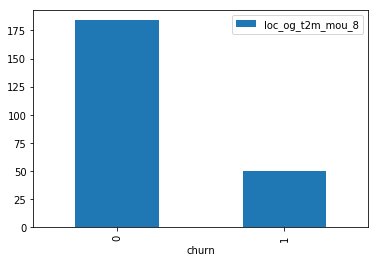

In [193]:
# Analysing 9th Important Feature

plotAvg(important_features_list[8])

The ninth important factor affecting churn is the local outgoing calls to other mobile operators for the 8th month. It can be seen that the average of the local outgoing calls to other mobile operators in the 8th month is considerably less for the churners as compared to the non-churners. This could mean that the customer could have switched to another provider but is still using the current provider to make some of the calls to other mobile operators. 

A possible strategy would be check for the local outgoing calls to other mobile operators for the 8th month for every customer and if it is below 50, then this customer would be likely to churn and can be targeted with talktime packages that offer discounts and low call charges on all local outgoing calls to other mobile opeartors to make the customer to reconsider swithcing to other networks and prevent the customer from churning. 

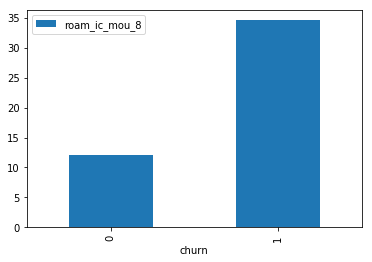

In [194]:
# Analysing 10th Important Feature

plotAvg(important_features_list[9])

The tenth important factor affecting churn is the total incoming calls for the 8th month while the customer is in roaming zone. It can be seen that while the customer is in roaming zone, the average incoming calls for the 8th month is considerably more for the churners as compared to the non-churners. This could mean that the customer has moved to a region outside the region under which the current network provider service was enabled and hence most of the incoming calls would be registered in the roaming zone. This could mean that the customer is looking to change to a new network provider in his/her current region.

A possible strategy would be check for the incoming calls in roaming zone during the 8th month for every customer and if it is above 13, then this customer would be likely to switch to new local telecom operator and can be targeted with new offers and talktime/data plans available in the customers current region, to keep the customer from chruning.

## Disclaimer : 
We have used the example file given in Upgrad, however we added our thought whenever required while analyzing the data and writing code.